**A.** Préliminaires

**A.1.** Imports :

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir as ls
from os.path import join
import time
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torchvision
import torch.nn as nn   
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import copy
import pickle
import time


torch.manual_seed(0)

**A.2.** Montage du répertoire contenant les sources et le dataset (pour colab):

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


**A.3.** imports locaux 

In [90]:
import sys
sys.path.insert(1, '/home/mdso/lepetitp/ppc/WEBCAMS/src/samecamera/training_samecamera')
sys.path.insert(1, '/home/mdso/lepetitp/ppc/WEBCAMS/src/images2sqlite')

from importlib import reload
import utile_ds_tr_series
from utile_ds_tr_series import *
from utile_trainReId import *
from utile_architectures import *
import utile_online_clustering

**A.4** Copie des répertoires et chemin

In [211]:
# dir_train = '/root/ds_sameCamera/ds_sameCamera_train'
# dir_val = '/root/ds_sameCamera/ds_sameCamera_val'
# dir_test = '/root/ds_sameCamera/ds_sameCamera_test'
# dir_series = '/root/ds_sameCamera/ds_sameCamera_series_v2'

dir_train = '/scratch/mdso/lepetitp/ppc/WEBCAMS/jeux_apprentissage/jeux_sameCamera/ds_sameCamera_train_new'
dir_val = '/scratch/mdso/lepetitp/ppc/WEBCAMS/jeux_apprentissage/jeux_sameCamera/ds_sameCamera_val_new'
dir_test = '/scratch/mdso/lepetitp/ppc/WEBCAMS/jeux_apprentissage/jeux_sameCamera/ds_sameCamera_test_new'
dir_series = '/scratch/mdso/lepetitp/ppc/WEBCAMS/jeux_apprentissage/jeux_sameCamera/series_test_v2'
dir_models = '/scratch/mdso/lepetitp/ppc/WEBCAMS/models/sameCamera2/'

**C.** Visualisation des données

**D.** Entraînement

**F.** Test d'un online clustering

**F.1** Apprentissage du seuillage

**F.1.1** Visualisation d'une séquence

In [139]:
tr_ReID_series(size_in, size_out, tail=150)

150


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14])


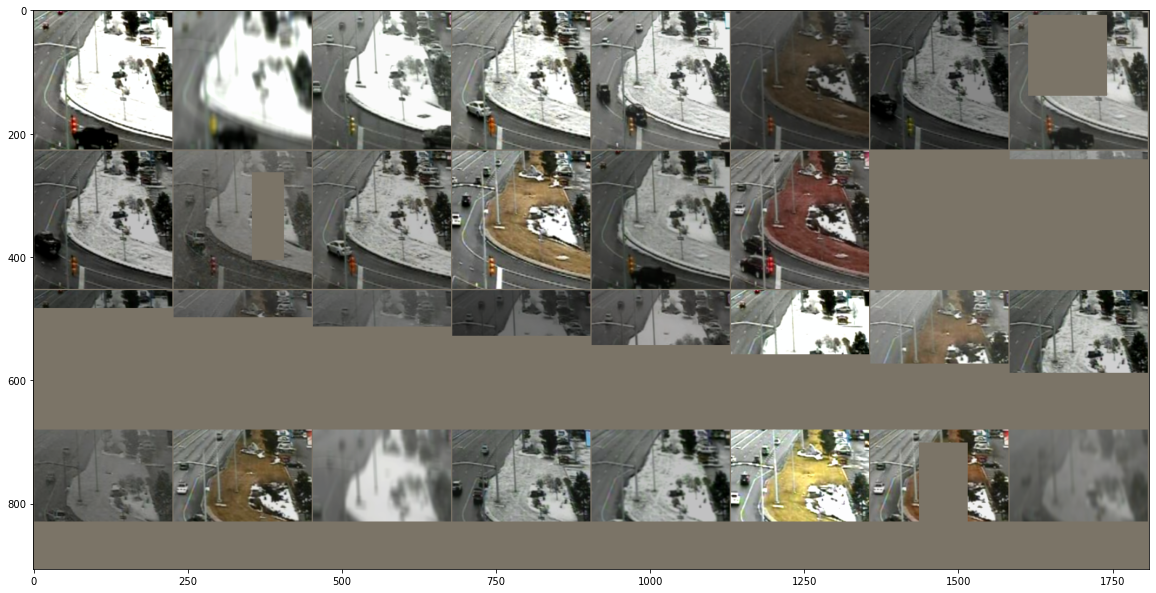

In [225]:
reload(utile_ds_tr_series)
from utile_ds_tr_series import *

# Instance of transforms:
size_in = 256+32
size_out = 256-32
tr_series = tr_ReID_series(size_in, size_out, tail=10)


# Instance of Dataset_ReID

kwargs = {'size_in': size_in,
          'size_out': size_out,
          'angle_max':10,
          'ph':0.20,  
          'pv':0.15,
          'marginsup':0.1,
          'margininf':0.1,
          'cropped_prop':0.75,
          'zoom':33,
          'ptrans':0.
          }


#  états possibles:
num_seq = 1
num_subseq = 2

# serie de longueur 16
len_series = 32
batch_size_viz = 1
ds_OLC_viz = Dataset_OLC(dir_test, tr_series, num_seq, num_subseq, len_series, **kwargs)
dl_OLC_viz = torch.utils.data.DataLoader(ds_OLC_viz,
                                          batch_size=batch_size_viz, 
                                          shuffle=False, 
                                          num_workers=2)


it = iter(dl_OLC_viz)
imgs, labels, names, reps, angles, sawtooths, endpoints, croppings, flips = next(it)

## Make a grid from batch
# print(imgs.shape)
print(labels[0,:,0])
# print(reps.flatten())
# print(angles.flatten())
print(sawtooths.flatten())
# print(endpoints[0,...].t())
# print(croppings[0,...].t())
# print(flips.flatten())
# print(labels.shape)
# print(names)
imgs = imgs.reshape((batch_size_viz * len_series, 3, size_out, size_out))
out0 = torchvision.utils.make_grid(imgs)

#
def imshow(inp, title=None):
    #Imshow for Tensor
    plt.figure(figsize = (20,20))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

imshow(out0)

In [73]:
print(names)

[('19507_1/19507_20130504_164102.jpg', '977_0/977_20100301_135341.jpg'), ('19507_1/19507_20130504_221104.jpg', '977_0/977_20100301_135341.jpg'), ('19507_1/19507_20130504_131111.jpg', '977_0/977_20100301_182344.jpg'), ('19507_1/19507_20130503_231110.jpg', '977_0/977_20100302_222349.jpg'), ('19507_1/19507_20130504_131111.jpg', '977_0/977_20100301_185344.jpg'), ('19507_1/19507_20130504_221104.jpg', '977_0/977_20100304_212354.jpg'), ('19507_1/19507_20130502_124109.jpg', '977_0/977_20100301_185344.jpg'), ('19507_1/19507_20130504_184106.jpg', '977_0/977_20100301_185344.jpg'), ('19507_1/19507_20130502_141112.jpg', '977_0/977_20100301_125340.jpg'), ('19507_1/19507_20130502_141112.jpg', '977_0/977_20100304_132339.jpg'), ('19507_1/19507_20130504_164102.jpg', '977_0/977_20100304_212354.jpg'), ('19507_1/19507_20130504_221104.jpg', '977_0/977_20100305_152341.jpg'), ('19507_1/19507_20130502_141112.jpg', '977_0/977_20100303_152341.jpg'), ('19507_1/19507_20130502_141112.jpg', '977_0/977_20100304_13233

**F.2** test sur les données réelles.

In [270]:
reload(utile_online_clustering)
from utile_online_clustering import OnlineClustering_v2
from utile_online_clustering import multi_Lp_dist

archi = 'resnet50_nl'
dir_models = '/scratch/mdso/lepetitp/ppc/WEBCAMS/models/sameCamera'
device = torch.device('cpu')

# chargement du modèle:
if archi == 'resnet50':
    num_latentdims = 100
    resnet = torchvision.models.resnet50(pretrained=False)
    resnet.fc = nn.Linear(resnet.fc.in_features, num_latentdims)
    PATH_final_checkpoint = join(dir_models, "resnet50_eraser_final_checkpoint") #r"../models/resnet50_200ep_checkpoint"-> lastepoq ou r"../models/resnet50_100ep_checkpoint" -> best epoch
    weights_resnet = torch.load(PATH_final_checkpoint, map_location=device)
    resnet.load_state_dict(weights_resnet['model_state_dict'])

if archi == 'resnet50_nl':
    PATH_bestacc_checkpoint = join(dir_models, archi + "_1gpu_bm.checkpoint")
    PATH_lastepo_checkpoint = join(dir_models, archi + "_1gpu_le.checkpoint")
    PATH_bm2 = join(dir_models, archi + "_daug2_sched100_1gpu_bm.checkpoint")
    PATH_le2 = join(dir_models, archi + "_daug2_sched100_1gpu_le.checkpoint")

    PATH_checkpoint = PATH_bm2
        
    gem_pool = True
    # resnet = torchvision.models.resnet50(progress=True)
    # torch.save(resnet.state_dict(), path_ResNet50_weights)
    last_stride = 1 
    model_path = ''
    model_name = 'resnet50_nl' 
    gem_pool = 'on'
    pretrain_choice = None
    num_latentdims = 2048
    resnet = Baseline(num_latentdims, last_stride, 
                      None, model_name,
                      gem_pool, None)
    checkpoint = torch.load(PATH_checkpoint, map_location=device)
    resnet.load_state_dict(checkpoint['model_state_dict'])



for module in resnet.modules():
    for param in module.parameters():
        param.requires_grad = False

contrastive_model = resnet
contrastive_model = contrastive_model.to(device)
contrastive_model.eval()





Generalized Mean Pooling


In [327]:
reload(utile_ds_tr_series)
from utile_ds_tr_series import *

tr_series = tr_ReID_series(size_in, size_out, tail=30)

kwargs_train = {'size_in': size_in,
                'size_out': size_out,
                'angle_max':10,
                'ph':0.20,  
                'pv':0.15,
                'marginsup':0.1,
                'margininf':0.1,
                'cropped_prop':0.75,
                'zoom':33,
                'ptrans':0.
                }

#  états possibles:
num_seq = 2
num_subseq = 1

# serie de longueur 30
len_series = 60
batch_size = 1
nb_images_for_init = 5
ds_OLC = Dataset_OLC(dir_test, tr_series, num_seq, num_subseq, len_series,
                     **kwargs_train)
dl_OLC = torch.utils.data.DataLoader(ds_OLC,
                                          batch_size=batch_size, 
                                          shuffle=False, 
                                          num_workers=2)


tensor([29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29])
10.000
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 98.5204, 98.4451, 98.4757,
        98.4553, 98.4548, 98.4574, 98.4245, 98.4308, 98.4566, 98.4256, 98.4332,
        98.4414, 98.44

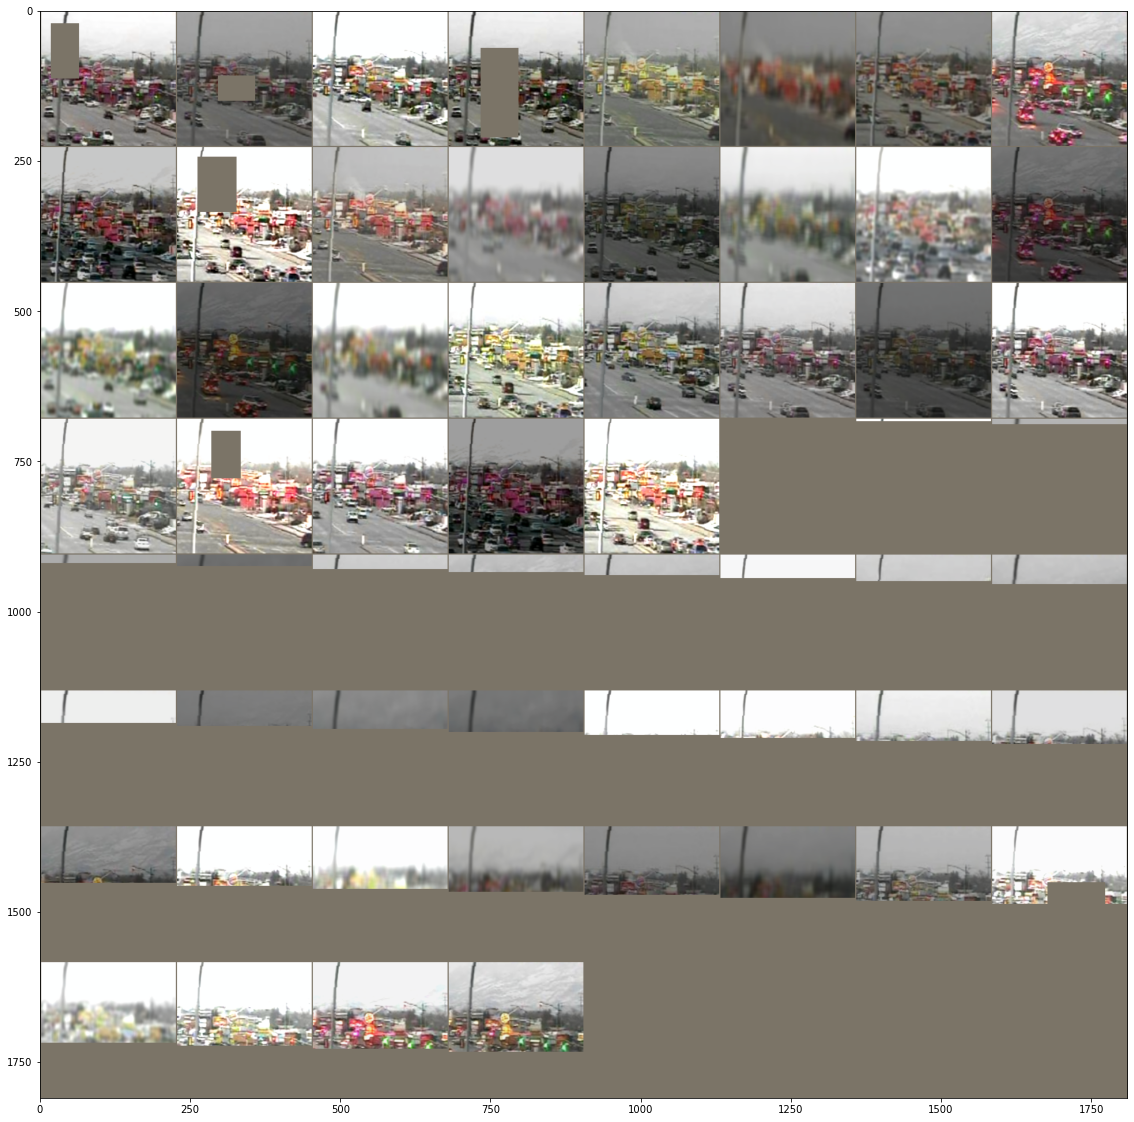

In [330]:
reload(utile_online_clustering)
from utile_online_clustering import OnlineClustering_v2

oc = OnlineClustering_v2()
oc = oc.to(device)
# Init:
lr = 0.1 #avec adam pour resnet simple
optimizer = torch.optim.Adam(oc.parameters(), lr=lr, betas=(0.7, 0.999))
criterion = nn.CrossEntropyLoss()

it = iter(dl_OLC)
imgs, labels, names, reps, angles, sawtooths, endpoints, croppings, flips = next(it)


print(sawtooths.flatten())

# apply oc_v2:

images = imgs.to(device)
labels = labels.to(device)
with torch.no_grad():
    # apply contrastive_model:
    ns, size, *im_shape = images.shape
    images = images.reshape((ns*size,*im_shape))
    fv = contrastive_model(images)
    fv = fv.reshape(ns, size, num_latentdims)

    # init oc
    fv_init = fv[:, :nb_images_for_init, ...]
    nc_max = 5
    oc.init_cluster(fv_init, nc_max, device=device)

    # apply oc.
    running_preds = [torch.zeros(nb_images_for_init)]
    running_predsnew = [torch.zeros(nb_images_for_init)]
    running_labels = [torch.zeros(nb_images_for_init,3)]
    running_loss = [torch.zeros(nb_images_for_init)]
    running_dic =  [torch.zeros(nb_images_for_init)]
    loss = 0.

    for k in range(nb_images_for_init, len_series):
        fv_k = fv[:, k, ...]
        proba_new_cluster, proba_clusters, clusters = oc.forward(fv_k, device=device)

        optimizer.zero_grad()
        #        loss = criterion(proba_clusters, labels[:, k, 0])
        loss += criterion(proba_new_cluster, labels[:, k, 2])


        running_preds.append(clusters.cpu())
        running_predsnew.append(torch.max(proba_new_cluster, dim=1)[1].cpu())
        running_labels.append(labels[:, k, :].cpu())
        running_dic.append(multi_Lp_dist(oc.clusters['meanc'][:,[0],:], oc.clusters['meanc'][:,[1],:])[0,0,:])
        running_loss.append(loss.detach().cpu().item())
        

        # valeur de bascule:
        bas = oc.raw_threshold.detach().item()
        
    

    bas = oc.raw_threshold
    per = oc.perceptron[0].weight
    print( '%5.3f' % (bas).item())
    # print(per)
    # print(oc.get_fine_threshold[0].weight)
    running_preds = torch.cat(running_preds, dim=0)
    running_predsnew = torch.cat(running_predsnew, dim=0)
    running_labels = torch.cat(running_labels, dim=0)
    running_dic = torch.cat(running_dic, dim=0)
    acc = (running_preds == running_labels[...,0]).sum().float() / running_preds.numel()
    acc_new = (running_predsnew == running_labels[...,2]).sum().float() / running_preds.numel()
    print(running_preds)
    print(running_labels[:,0])
    print(running_dic)
    print(oc.clusters['branching'])
    

imgs = imgs.reshape((batch_size * len_series, 3, size_out, size_out))
out0 = torchvision.utils.make_grid(imgs)

def imshow(inp, title=None):
    #Imshow for Tensor
    plt.figure(figsize = (20,20))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

imshow(out0)



In [323]:
counter = torch.arange(5).expand(2, 5)
print(counter)

dist = 20*torch.rand((2,5)) 
print(dist)
argmins = torch.tensor([1, 1])
print(argmins.view(2,1).repeat(1,5))
where_inf_thresh_same = torch.where(dist < 9., counter, argmins.view(2,1).repeat(1,5))
print(where_inf_thresh_same)
argmins_, _ = torch.min(where_inf_thresh_same, dim=1)
print(argmins_)


tensor([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]])
tensor([[ 5.8611,  3.2288, 12.2629, 14.5971,  1.2570],
        [12.6825, 16.9856,  5.5986, 12.3488,  0.4604]])
tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]])
tensor([[0, 1, 1, 1, 4],
        [1, 1, 2, 1, 4]])
tensor([0, 1])


In [340]:
reload(utile_online_clustering)
from utile_online_clustering import OnlineClustering_v2

oc = OnlineClustering_v2()
oc = oc.to(device)
oc.eval()
# pas de prise de rique:
# seuil neige: 9.5
#seuil brouillard: 9.25
size_in = 256+32
size_out = 256-32
batch_size = 64
marginsup = 0.1
marginsup = 0.1
cropped_prop = 0.7
SC = Simple_crop_sequences(marginsup, marginsup, cropped_prop, size_in, size_out)



nb_images_for_init = 5
nc_max = 10
start = 4
cams = sorted([cam for cam in ls(dir_series) if 'webcam' in cam]) # ['webcam1348','webcam1399'] 
preds = {cam:[0 for i in range(nb_images_for_init)] for cam in cams}
branchings = {}

for cam in cams:
  print(cam)
  ds = DS_singleton_sequences(join(dir_series, cam), SC)
  dl = torch.utils.data.DataLoader(ds, shuffle = False, 
                                   batch_size=16, num_workers=4)

  feats = []
  running_preds_byseq = []
  i = 0
  

  with torch.no_grad():
      for images, names in dl:
          # print(names)
          images = images.to(device)
          bs, *_ = images.shape
          with torch.no_grad():
            fv = contrastive_model(images)
          fv = fv.reshape(1, bs, num_latentdims)

          if i==0:
              i = 1
              fv_init = fv[:, :nb_images_for_init, ...]
              nc_max = 5
              oc.init_cluster(fv_init, nc_max, device=device)
              idxs = range(nb_images_for_init, bs)
          else:
              idxs = range(bs)

          for k in idxs:
              fv_k = fv[:, k, ...]
              _, _, cluster = oc.forward(fv_k, device=device)
              cluster = cluster.item()
              running_preds_byseq.append(cluster)
  branchings[cam] = oc.clusters.get('branching')

  preds[cam] += running_preds_byseq
#   path_dict_clusters = '/root/' + cam + '_dict_clusters.pt' 
#   oc.save_dict_clusters(path_dict_clusters)


webcam1192
webcam1198
webcam1203
webcam1209
webcam1213
webcam1230
webcam1240
webcam1249
webcam1268
webcam1284
webcam1323
webcam1343
webcam1346
webcam1348
webcam1381
webcam1399
webcam1439


In [341]:
def reduce(L):
  l = len(L)
  new_L = []
  current_cl = L[0]
  count = 0
  for i, cl in enumerate(L):
    if cl == current_cl:
      count+=1
    else:
      new_L.append((current_cl,count))
      current_cl = cl 
      count = 1
    if i == l-1:
      new_L.append((current_cl,count))
  return new_L


# Etude clusters parasites : 

obs = {}
com = {}
com['webcam1323'] = 'tunnel lac de chanmbon'
obs['webcam1323'] = []

com['webcam1198'] = 'Menat'
obs['webcam1198'] = [(0, 41), (1, 2), ('flou dégressif', 16), (0, 75), ('flou dégressif', 7), (0, 94), (3, 2), (0, 44)]

com['webcam1203'] = 'split flou'
obs['webcam1203'] = [(0, 44), ('0, très flou', 14), ('0, léger flou',13), (0, 17)]

com['webcam1209'] = 'saletés'
obs['webcam1209'] = [(0)]


com['webcam1192'] = 'superbesse, split pixels gris'
obs['webcam1192'] = []

com['webcam1297'] = ''
obs['webcam1297'] = []

com['webcam1296'] = ''
obs['webcam1296'] = []

com['webcam1323'] = 'split camions'
obs['webcam1323'] = []

com['webcam1192'] = ""
obs['webcam1192'] = []

com['webcam1381'] = 'station aigual, split brouillard non rerpoduit à th = 10'
obs['webcam1381'] = []

com['webcam1213'] = 'chalet, zoom' 
obs['webcam1213'] = []

com['webcam1284'] = 'col de la ventouse, Aydat'
obs['webcam1284'] = []



com['webcam1268'] = 'Zoufftgen, brouillard -> split'
obs['webcam1268'] = []

com['webcam1343'] = 'sur faible seuil seulement (9.5)'
obs['webcam1343'] = []



com['webcam1348'] = 'superbe cas: sans neige - flocon + neige neige -> 2 clusters'
obs['webcam1348'] = [(0, 38), (1, 4), (0, 1), (1, 1), (0, 38), (1, 6), ('0, flou', 39), (1, 2), (2, 2), (1, 1), ('0, flou -> non flou', 39), (1, 5), ('0, non flou', 39), (1, 1), (2, 1), (1, 3), (2, 1), (0, 2), ('0, non flou', 37), (1, 4)]

com['webcam1346'] = 'meussia split camions, seuil faible'
obs['webcam1346'] = []

com['webcam1240'] = 'cote de la main, split greypix + flocon - le pb ne semble pas se poser à 10.'
obs['webcam1240'] = []

com['webcam1249'] = 'split  flocon  le pb ne semble pas se poser'
obs['webcam1249'] = []

com['webcam1439'] = 'split défaut image, pas reproduit à 10.'
obs['webcam1439'] = []

com['webcam1230'] = ''
obs['webcam1230'] = []

com['webcam1399'] = 'split flou, très bon exemple'
obs['webcam1399'] = [(0, 44), ('0,flou', 2), (0, 2), ('0, flou', 2), ('0, léger flou' , 3), (0, 17)]

for cam in preds:
  print('-------')
  print(cam)
  # print((preds[cam])) 
  print(com[cam]) 
  print(obs[cam]) 
  print('pred:')
  print(reduce(preds[cam]))  
  print('branchings:')
  print(branchings[cam])

-------
webcam1192

[]
pred:
[(0, 53), (1, 1), (0, 1)]
branchings:
{0: [], 1: [], 2: [], 3: [], 4: []}
-------
webcam1198
Menat
[(0, 41), (1, 2), ('flou dégressif', 16), (0, 75), ('flou dégressif', 7), (0, 94), (3, 2), (0, 44)]
pred:
[(0, 41), (1, 2), (2, 16), (0, 176), (3, 2), (0, 44)]
branchings:
{0: [], 1: [], 2: [0, 0], 3: [], 4: [], 5: []}
-------
webcam1203
split flou
[(0, 44), ('0, très flou', 14), ('0, léger flou', 13), (0, 17)]
pred:
[(0, 44), (1, 22), (0, 2), (1, 1), (0, 89)]
branchings:
{0: [], 1: [0, 0, 0], 2: [], 3: [], 4: []}
-------
webcam1209
saletés
[0]
pred:
[(0, 129)]
branchings:
{0: [], 1: [], 2: [], 3: [], 4: []}
-------
webcam1213
chalet, zoom
[]
pred:
[(0, 39), (1, 1), (0, 1), (1, 3), (0, 37), (1, 3), (0, 1), (1, 1), (0, 36), (1, 9), (0, 4), (1, 2), (0, 2), (1, 1), (0, 12), (1, 6), (0, 38), (1, 6), (0, 47), (1, 1), (0, 41), (1, 3)]
branchings:
{0: [], 1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2: [], 3: [], 4: []}
-------
webcam1

Anciens codes:

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


9.600
Parameter containing:
tensor([[-1.1000],
        [ 1.1000]], device='cuda:0', requires_grad=True)
tensor(0.8771)
tensor(0.9943)
9.696
Parameter containing:
tensor([[-1.1906],
        [ 1.1906]], device='cuda:0', requires_grad=True)
tensor(0.8400)
tensor(0.9829)
9.778
Parameter containing:
tensor([[-1.2631],
        [ 1.2631]], device='cuda:0', requires_grad=True)
tensor(0.9229)
tensor(0.9857)
9.859
Parameter containing:
tensor([[-1.3347],
        [ 1.3347]], device='cuda:0', requires_grad=True)
tensor(0.9171)
tensor(0.9886)
9.934
Parameter containing:
tensor([[-1.4091],
        [ 1.4091]], device='cuda:0', requires_grad=True)
tensor(1.)
tensor(1.)
9.990
Parameter containing:
tensor([[-1.4790],
        [ 1.4790]], device='cuda:0', requires_grad=True)
tensor(0.9257)
tensor(0.9943)
10.049
Parameter containing:
tensor([[-1.5501],
        [ 1.5501]], device='cuda:0', requires_grad=True)
tensor(0.8429)
tensor(0.9886)
10.085
Parameter containing:
tensor([[-1.6139],
        [ 1.6139]], d

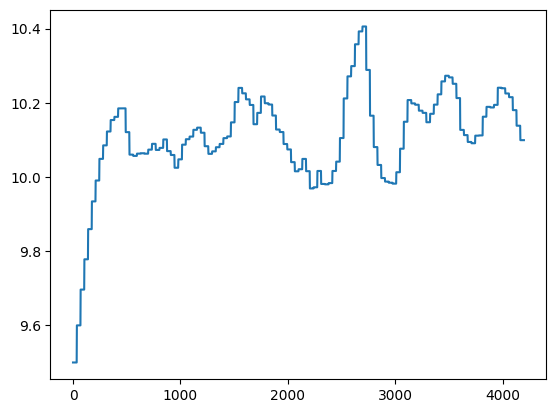

In [ ]:
#%% Train oc
num_trainepochs = 1
nb_images_for_init = 5
thresholds = []
losses = []
accs = []
accs_change = []
accs_new = []


for e in range(num_trainepochs):
  for i, (images, labels, names, *_) in enumerate(dl_OLC):

      images = images.cuda()
      labels = labels.cuda()

      # apply contrastive_model:
      ns, size, *im_shape = images.shape
      images = images.reshape((ns*size,*im_shape))
      with torch.no_grad():
        fv = contrastive_model(images)
      fv = fv.reshape(ns, size, num_latentdims)

      # init oc
      fv_init = fv[:, :nb_images_for_init, ...]
      nc_max = 5
      oc.init_cluster(fv_init, nc_max)
      
      # apply oc.
      running_preds = []
      running_predsnew = []
      running_labels = []
      running_loss = []
      loss = 0.

      for k in range(nb_images_for_init, len_series):
          fv_k = fv[:, k, ...]
          proba_new_cluster, proba_clusters, clusters = oc.forward(fv_k)
          
          optimizer.zero_grad()
  #        loss = criterion(proba_clusters, labels[:, k, 0])
          loss += criterion(proba_new_cluster, labels[:, k, 2])

          with torch.no_grad():
              running_preds.append(clusters.cpu())
              running_predsnew.append(torch.max(proba_new_cluster, dim=1)[1].cpu())
              running_labels.append(labels[:, k, :].cpu())
              running_loss.append(loss.detach().cpu().item())
              
              # valeur de bascule:
              bas = oc.raw_threshold.detach().item()
              thresholds.append(bas)

      loss.backward()
      optimizer.step()

      bas = oc.raw_threshold
      per = oc.perceptron[0].weight
      print( '%5.3f' % (bas).item())
      print(per)
      # print(oc.get_fine_threshold[0].weight)
      running_preds = torch.cat(running_preds, dim=0)
      running_predsnew = torch.cat(running_predsnew, dim=0)
      running_labels = torch.cat(running_labels, dim=0)
      
      acc = (running_preds == running_labels[...,0]).sum().float() / running_preds.numel()
      acc_new = (running_predsnew == running_labels[...,2]).sum().float() / running_preds.numel()
      
      accs_new.append(acc_new)
      accs.append(acc)
      losses.append(loss)
      print(acc)
      print(acc_new)
  #    print(oc.threshold[0].weight[0],oc.threshold[0].weight[1],oc.threshold[0].bias)

plt.plot(thresholds)

In [ ]:
# test
tr_series_test = tr_ReID_series(size_in, size_out)
kwargs_test = kwargs_train

#  états possibles:
num_seq_test = 4
num_subseq_test = 2

# serie de longueur 10
len_series_test = 10*4
batch_size_test = 1
ds_OLC_test = Dataset_OLC(dir_test, tr_series_test, num_seq_test, num_subseq_test,
                          len_series_test, **kwargs_test)
dl_OLC_test = torch.utils.data.DataLoader(ds_OLC_test,
                                          batch_size=batch_size_test, 
                                          shuffle=False, 
                                          num_workers=2)

In [ ]:
#%% Test
    
#print(labels[:,5])
num_epochs = 1
torch.manual_seed(0)

#% 
oc.eval()

accs_byseq = []

running_preds = []
running_labels = []
running_loss = []
nc_max = 10


for i, (images, labels, names, *_) in enumerate(dl_OLC_test):
    images = images.cuda()
    labels = labels.cuda()

    # apply contrastive_model:
    ns, size, *im_shape = images.shape
    images = images.reshape((ns*size,*im_shape))
    with torch.no_grad():
      fv = contrastive_model(images)
    fv = fv.reshape(ns, size, num_latentdims)

    # init oc
    fv_init = fv[:, :nb_images_for_init, ...]
    nc_max = 5
    oc.init_cluster(fv_init, nc_max)
    
    # apply oc.
    running_preds_byseq = []
    running_labels_byseq = []

    for k in range(nb_images_for_init, len_series_test):
        fv_k = fv[:, k, ...]
        proba_new_cluster, proba_clusters, clusters = oc.forward(fv_k)
        clusters = clusters.view((batch_size_test, 1))
        running_preds_byseq.append(clusters.cpu())
        running_labels_byseq.append(labels[:, [k]].cpu())
  
            

    running_preds_byseq = torch.cat(running_preds_byseq, dim=1)
    running_labels_byseq = torch.cat(running_labels_byseq, dim=1)    
        
    acc_byseq = (running_preds_byseq == running_labels_byseq[...,0])\
                                                     .sum(dim=1).float()\
                                / (len_series_test - nb_images_for_init)
    accs_byseq.append(acc_byseq.view(batch_size_test, 1))
    
    running_preds.append(running_preds_byseq.view(batch_size_test, 1,
                                          len_series_test - nb_images_for_init))
    running_labels.append(running_labels_byseq.view(batch_size_test, 1,
                                       len_series_test - nb_images_for_init, 3))
    
    print(i, acc_byseq)
    
    m, a = torch.min(acc_byseq, dim = 0)
    if  m < 0.99:
        images_to_see = images[a,...] 
        i_to_see = i 
        m_to_see = m
        a_to_see = a



0 tensor([0.9143])
1 tensor([1.])
2 tensor([1.])
3 tensor([1.])
4 tensor([1.])
5 tensor([1.])
6 tensor([0.5429])
7 tensor([1.])
8 tensor([1.])
9 tensor([1.])
10 tensor([1.])
11 tensor([1.])
12 tensor([1.])
13 tensor([1.])
14 tensor([1.])
15 tensor([1.])
16 tensor([0.9714])
17 tensor([1.])
18 tensor([0.1429])
19 tensor([0.7143])
20 tensor([1.])
21 tensor([1.])
22 tensor([0.6286])
23 tensor([1.])
24 tensor([1.])
25 tensor([1.])
26 tensor([0.4571])
27 tensor([1.])
28 tensor([0.7143])
29 tensor([1.])
30 tensor([1.])
31 tensor([0.7429])
32 tensor([1.])
33 tensor([1.])
34 tensor([1.])
35 tensor([0.5143])
36 tensor([1.])
37 tensor([1.])
38 tensor([0.5143])
39 tensor([0.1714])
40 tensor([1.])
41 tensor([1.])
42 tensor([1.])
43 tensor([1.])
44 tensor([1.])
45 tensor([1.])
46 tensor([1.])
47 tensor([1.])
48 tensor([1.])
49 tensor([1.])
50 tensor([1.])
51 tensor([1.])
52 tensor([0.7714])
53 tensor([0.6857])
54 tensor([1.])
55 tensor([0.3143])
56 tensor([0.6000])
57 tensor([0.9429])
58 tensor([1.]

In [ ]:
preds = torch.cat(running_preds, dim=1)
labels = torch.cat(running_labels, dim=1) 
accs_byseq = torch.cat(accs_byseq, dim=1) 

print('proportion de séquence erronées')
print((accs_byseq < 0.99).sum().float()/accs_byseq.numel())
acc = (preds == labels[...,0]).sum().float() / preds.numel()
print('justesse moyenne')
print(acc)
#%%

# Modèle avec resnet50_nl, bm2:
# proportion de séquence erronées
# tensor(0.1958)
# justesse moyenne
# tensor(0.9380)

proportion de séquence erronées
tensor(0.2011)
justesse moyenne
tensor(0.9324)


In [ ]:
# Qualitative:
# print(accs_byseq[a_to_see, i_to_see])
# preds_to_see = preds[a_to_see, i_to_see]
# labels_to_see = labels[a_to_see, i_to_see]

# for i, pred in enumerate(preds_to_see):
#     if pred != labels_to_see[i,0]:
#         ibeg = i
#         break
# print(ibeg)
# startviz = 5
# endviz = 40 - startviz
# print('preds')
# print(preds_to_see[ibeg - startviz:ibeg+endviz].view(-1,5))
# print('states')
# print(labels_to_see[ibeg - startviz:ibeg+endviz,0].view(-1,5))
# print('never seen states')
# print(labels_to_see[ibeg - startviz:ibeg+endviz,2].view(-1,5))


**G.** Test sur les séries d'images de la maquette:

nb de séquences homogènes :
55
('webcam1192_202211171015.jpg', 'webcam1192_202211171030.jpg', 'webcam1192_202211171044.jpg', 'webcam1192_202211171059.jpg', 'webcam1192_202211171114.jpg', 'webcam1192_202211171129.jpg', 'webcam1192_202211171144.jpg', 'webcam1192_202211171159.jpg', 'webcam1192_202212311105.jpg', 'webcam1192_202212311130.jpg', 'webcam1192_202212311140.jpg', 'webcam1192_202212311159.jpg', 'webcam1192_202212311214.jpg', 'webcam1192_202212311225.jpg', 'webcam1192_202212311244.jpg', 'webcam1192_202212311259.jpg', 'webcam1192_202301010705.jpg', 'webcam1192_202301010720.jpg', 'webcam1192_202301010740.jpg', 'webcam1192_202301010829.jpg', 'webcam1192_202301010840.jpg', 'webcam1192_202301010850.jpg', 'webcam1192_202301010914.jpg', 'webcam1192_202301010929.jpg', 'webcam1192_202301010944.jpg', 'webcam1192_202301010959.jpg', 'webcam1192_202301011014.jpg', 'webcam1192_202301011025.jpg', 'webcam1192_202301011114.jpg', 'webcam1192_202301011125.jpg', 'webcam1192_202301011140.jpg', 'webcam

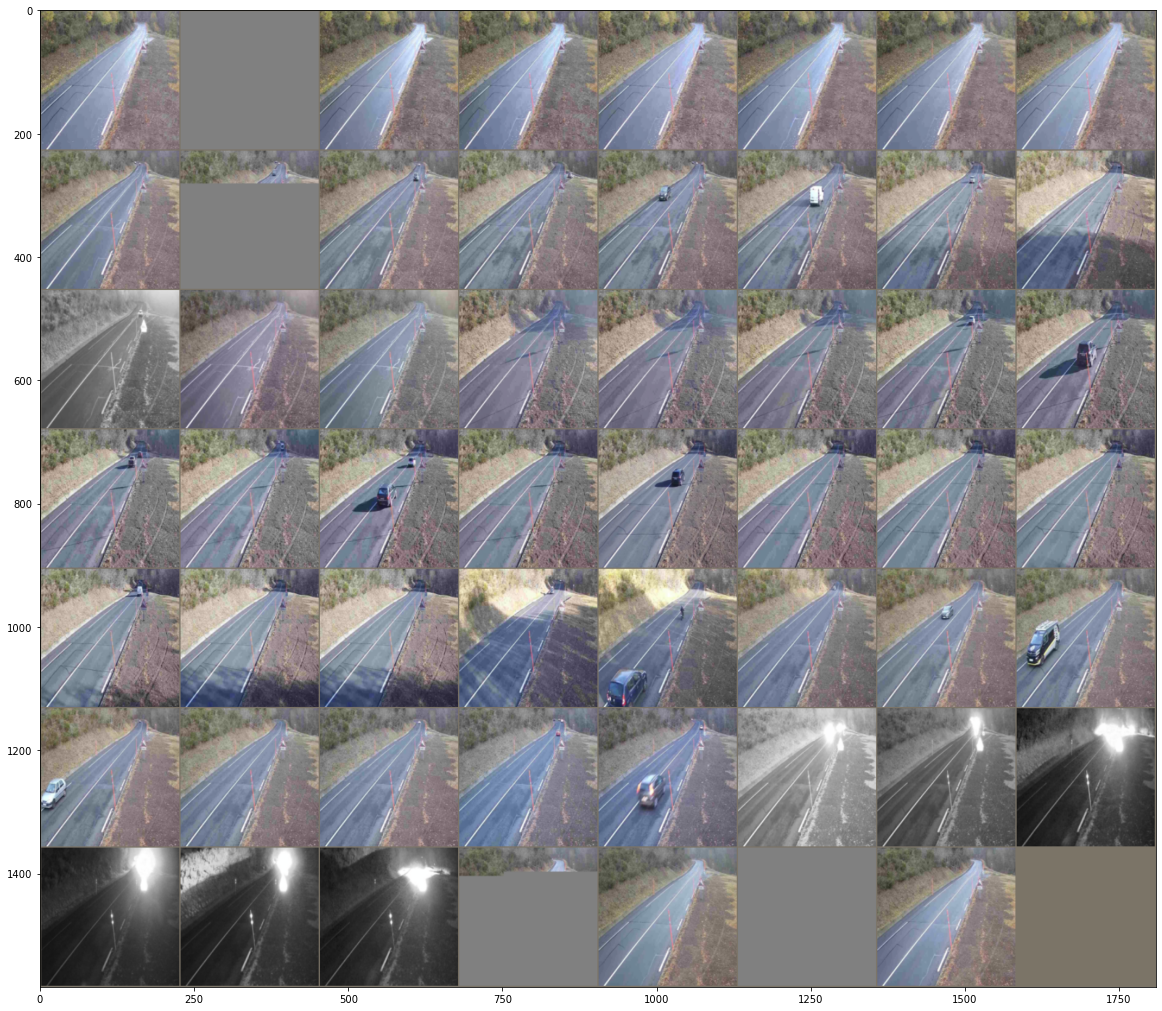

In [218]:
# test
size_in = 256+32
size_out = 256-32
batch_size = 64
marginsup = 0.1
marginsup = 0.1
cropped_prop = 0.7
SC = Simple_crop_sequences(marginsup, marginsup, cropped_prop, size_in, size_out)
ds = DS_singleton_sequences(join(dir_series, 'webcam1192'), SC )


print('nb de séquences homogènes :')
print(ds.__len__())

dl_viz = torch.utils.data.DataLoader(ds, shuffle = False, batch_size=batch_size, num_workers=2)

imga, namea = next(iter(dl_viz))
print(namea)

imga = imga.reshape((-1, 3, size_out, size_out))
out0 = torchvision.utils.make_grid(imga)

#
def imshow(inp, title=None):
    #Imshow for Tensor
    plt.figure(figsize = (20,20))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

imshow(out0)

In [ ]:
#%% Test:
archi = 'resnet50_nl'

# chargement du modèle:
if archi == 'resnet50':
    num_latentdims = 100
    resnet = torchvision.models.resnet50(pretrained=False)
    resnet.fc = nn.Linear(resnet.fc.in_features, num_latentdims)
    PATH_final_checkpoint = r"../models/resnet50_eraser_final_checkpoint" #r"../models/resnet50_200ep_checkpoint"-> lastepoq ou r"../models/resnet50_100ep_checkpoint" -> best epoch
    weights_resnet = torch.load(PATH_final_checkpoint, map_location=torch.device('cpu'))
    resnet.load_state_dict(weights_resnet['model_state_dict'])

if archi == 'resnet50_nl':
    PATH_bestacc_checkpoint = "../models/" + archi + "_1gpu_bm.checkpoint"
    PATH_lastepo_checkpoint = "../models/" + archi + "_1gpu_le.checkpoint"

    gem_pool = True
    # resnet = torchvision.models.resnet50(progress=True)
    # torch.save(resnet.state_dict(), path_ResNet50_weights)
    last_stride = 1 
    model_path = ''
    model_name = 'resnet50_nl' 
    gem_pool = 'on'
    pretrain_choice = None
    num_latentdims = 2048
    resnet = Baseline(num_latentdims, last_stride, 
                      None, model_name,
                      gem_pool, None)
    checkpoint = torch.load(PATH_lastepo_checkpoint)
    resnet.load_state_dict(checkpoint['model_state_dict'])

resnet = resnet.cuda()
resnet.eval()

Generalized Mean Pooling


Baseline(
  (base): ResNetNL(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_siz

In [ ]:
# calcul matrices de distances pour chaque cam:
dists = {}

cams = sorted([cam for cam in ls(dir_series) if 'webcam' in cam])

for cam in cams:

  ds = DS_singleton_sequences(join(dir_series, cam), SC)
  print('nb d images')
  print(ds.__len__())

  dl = torch.utils.data.DataLoader(ds, shuffle = False, batch_size=8, num_workers=2)

  feats = []
  with torch.no_grad():
    for images, names in dl:
      # print(names)
      images = images.cuda()
      feat = resnet(images)
      feats.append(feat.cpu())
  cat_feats = torch.cat(feats, dim=0).detach()
  dist = euclidean_dist(cat_feats, cat_feats)
  dists[cam] = dist.numpy()




nb d images
95
nb d images
36


/content/drive/MyDrive/sameCamera/src_real/utile_trainReId.py:65: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  dist.addmm_(1, -2, x, y.t())


nb d images
389
nb d images
36
nb d images
172
nb d images
338
nb d images
176
nb d images
128
nb d images
424
nb d images
36


webcam1192
webcam1268
webcam1291
webcam1293
webcam1322
webcam1324
webcam1325
webcam1341
webcam1347
webcam1425


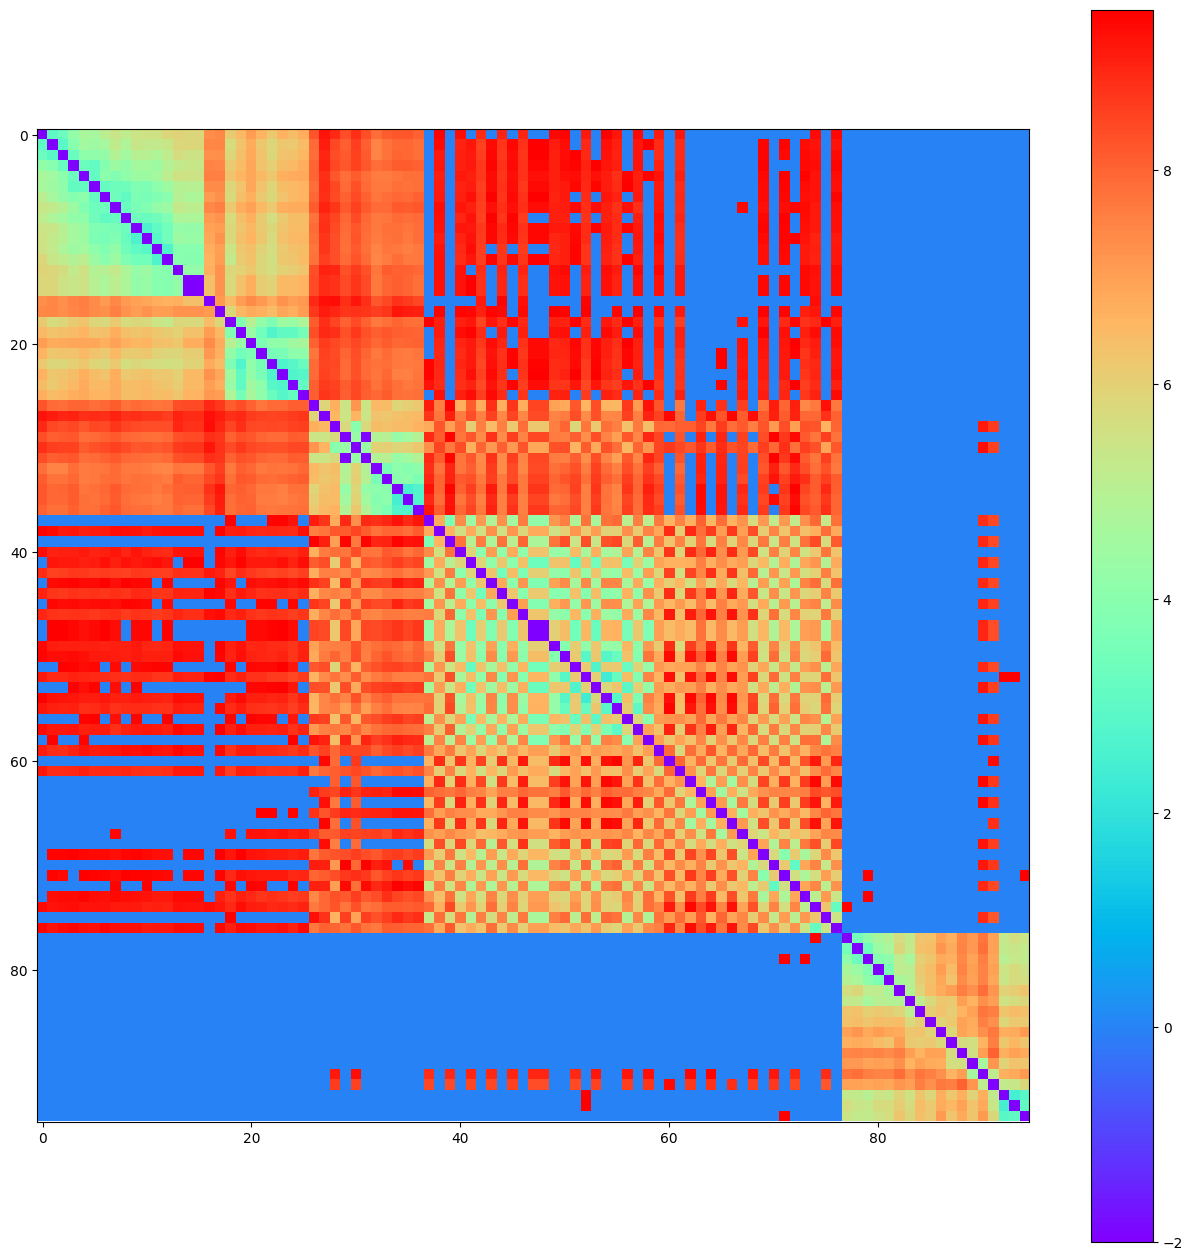

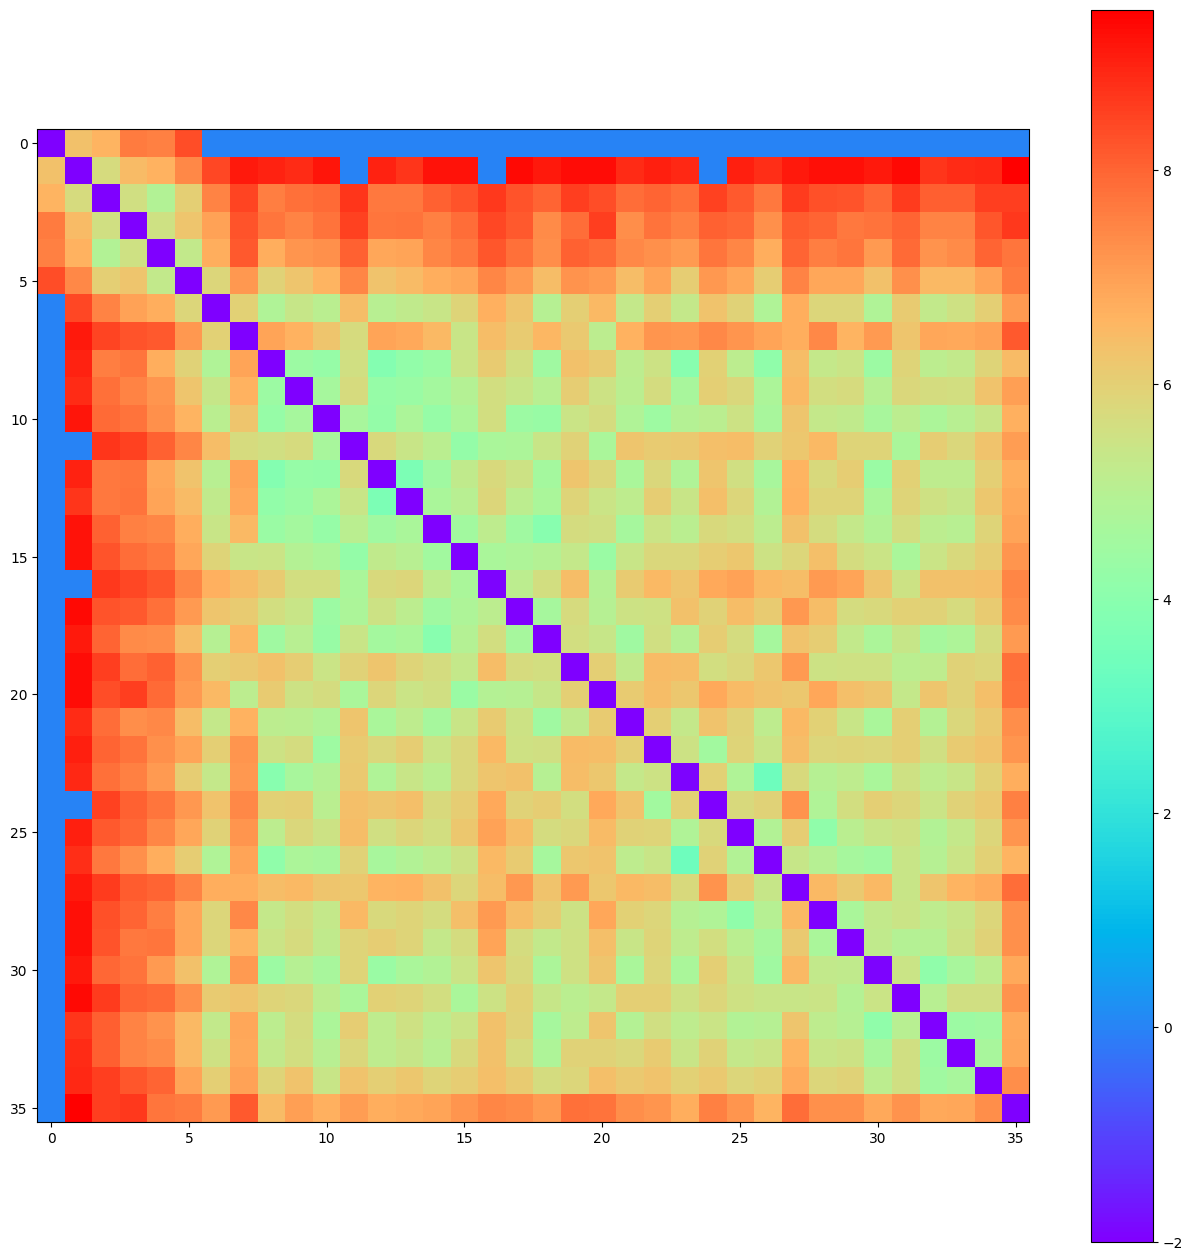

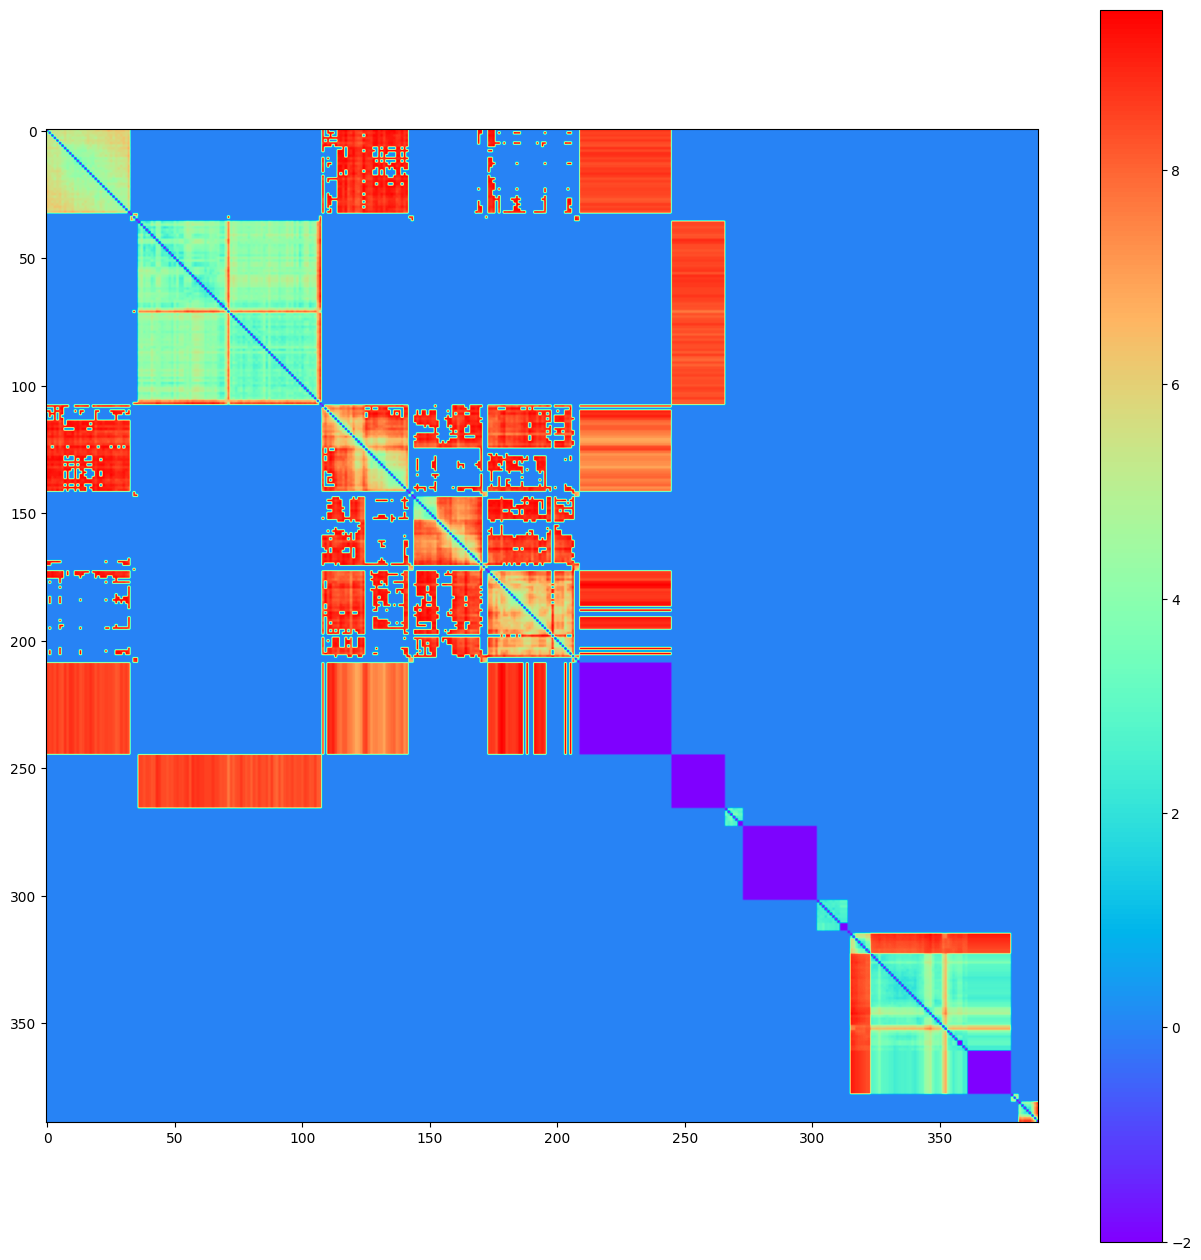

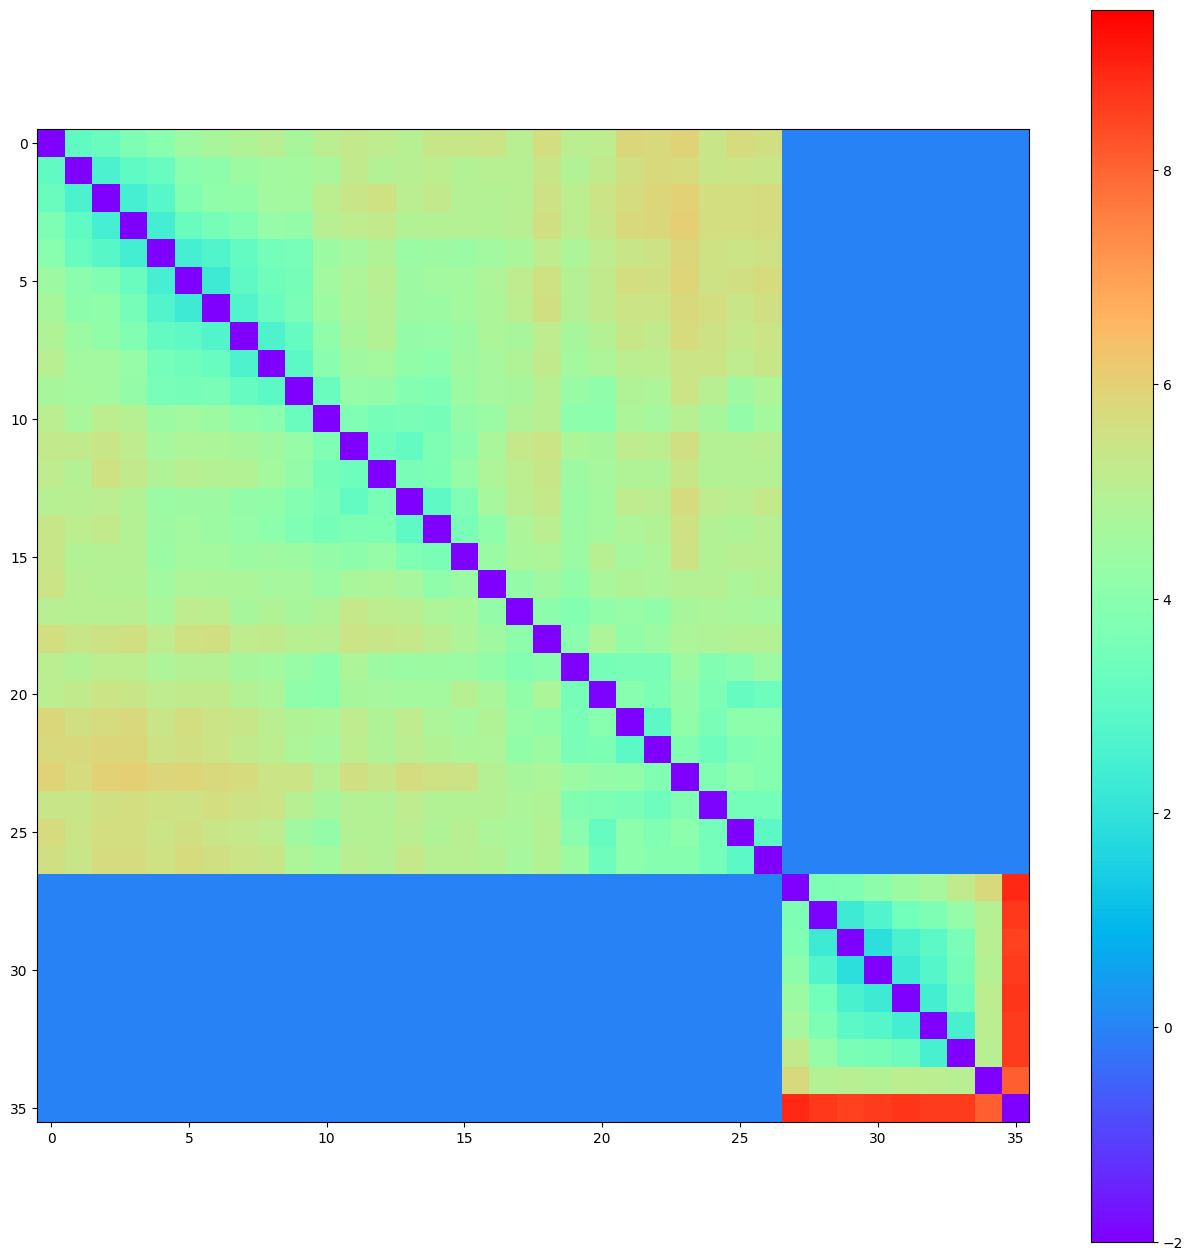

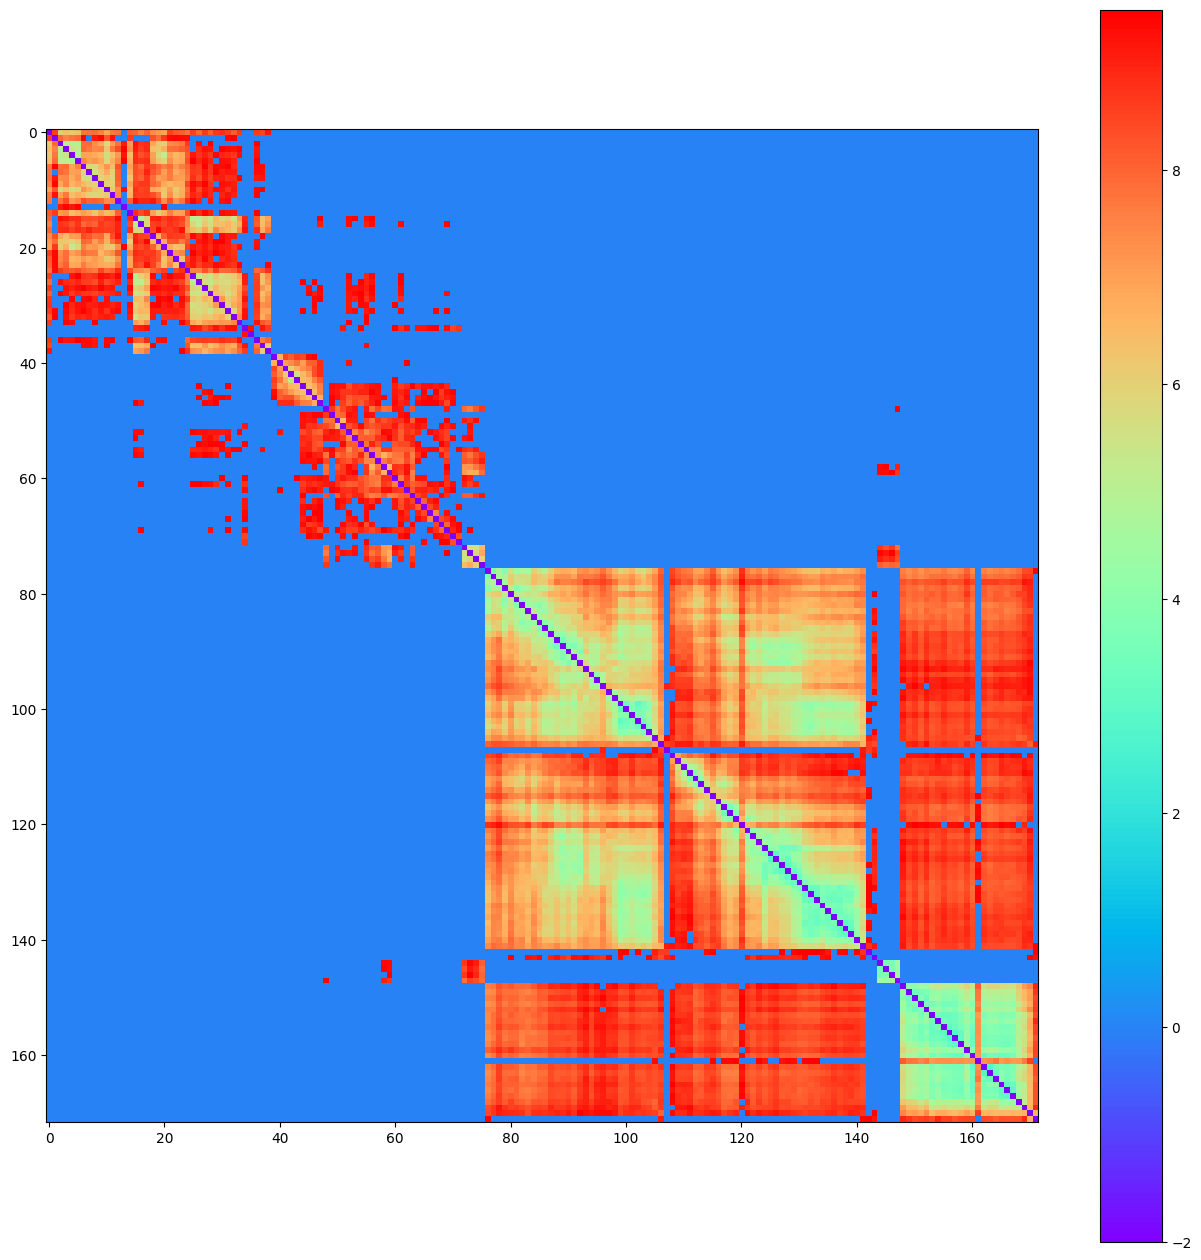

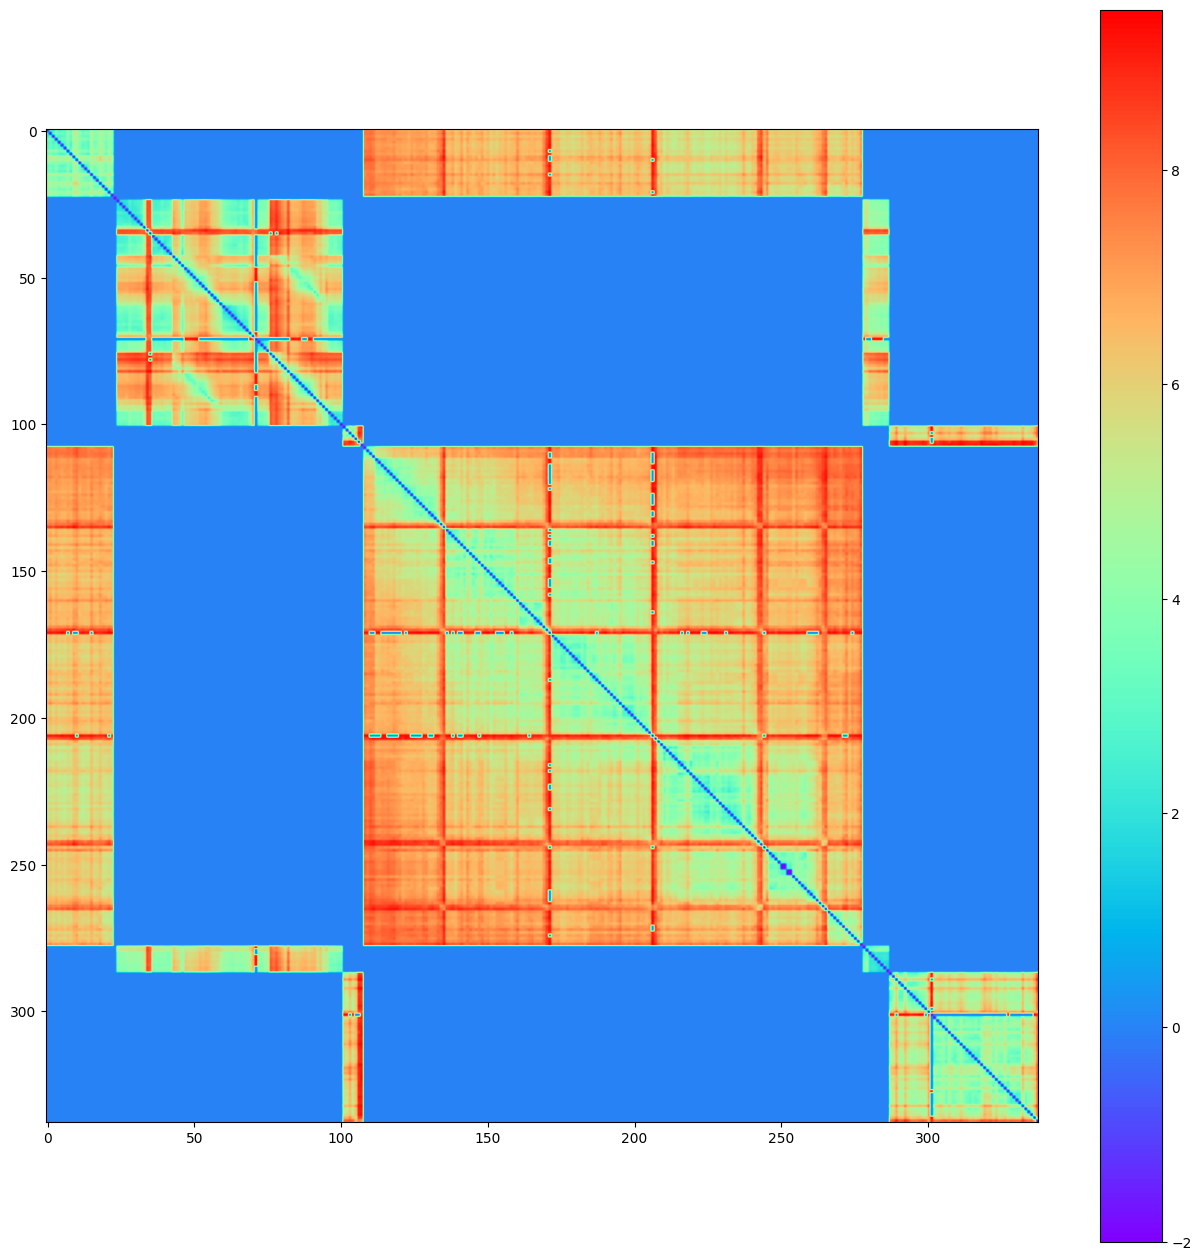

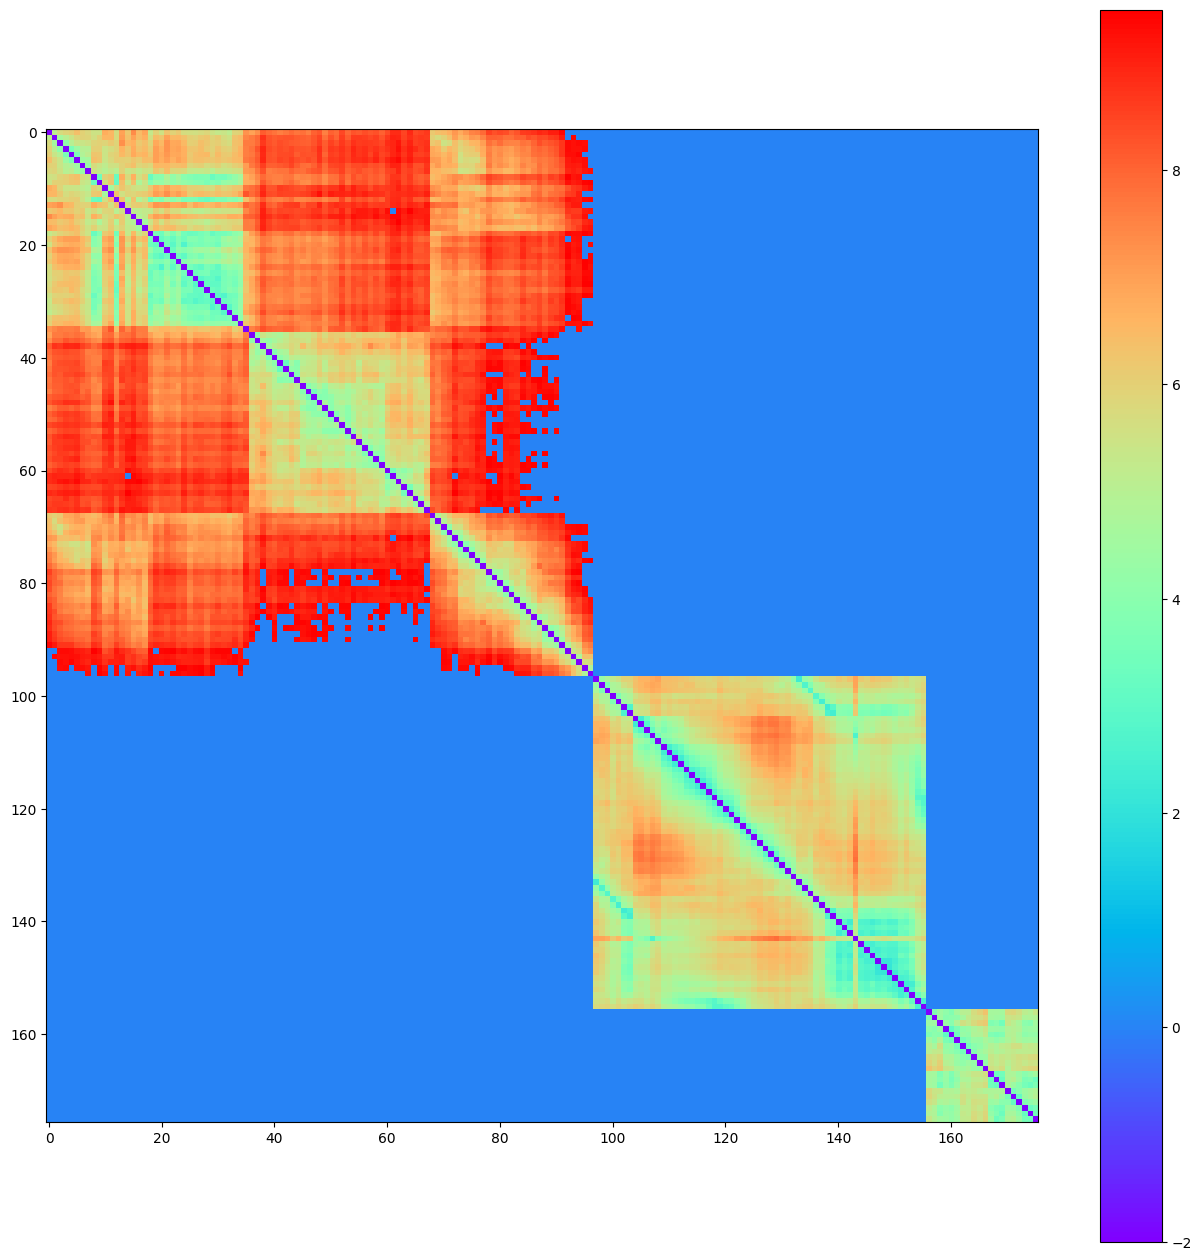

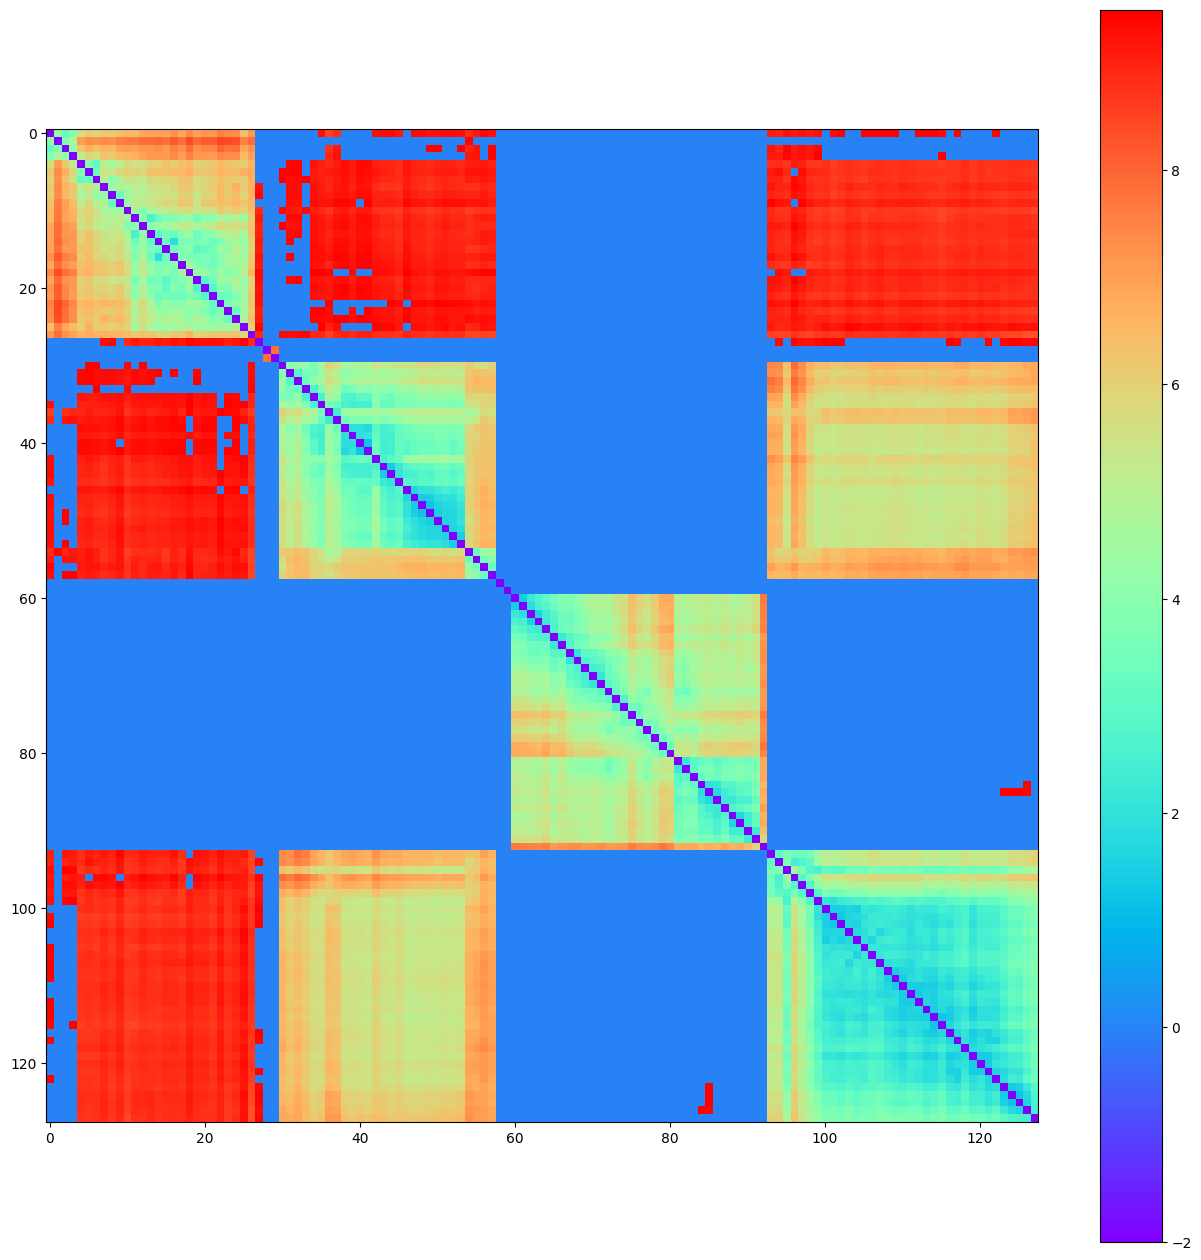

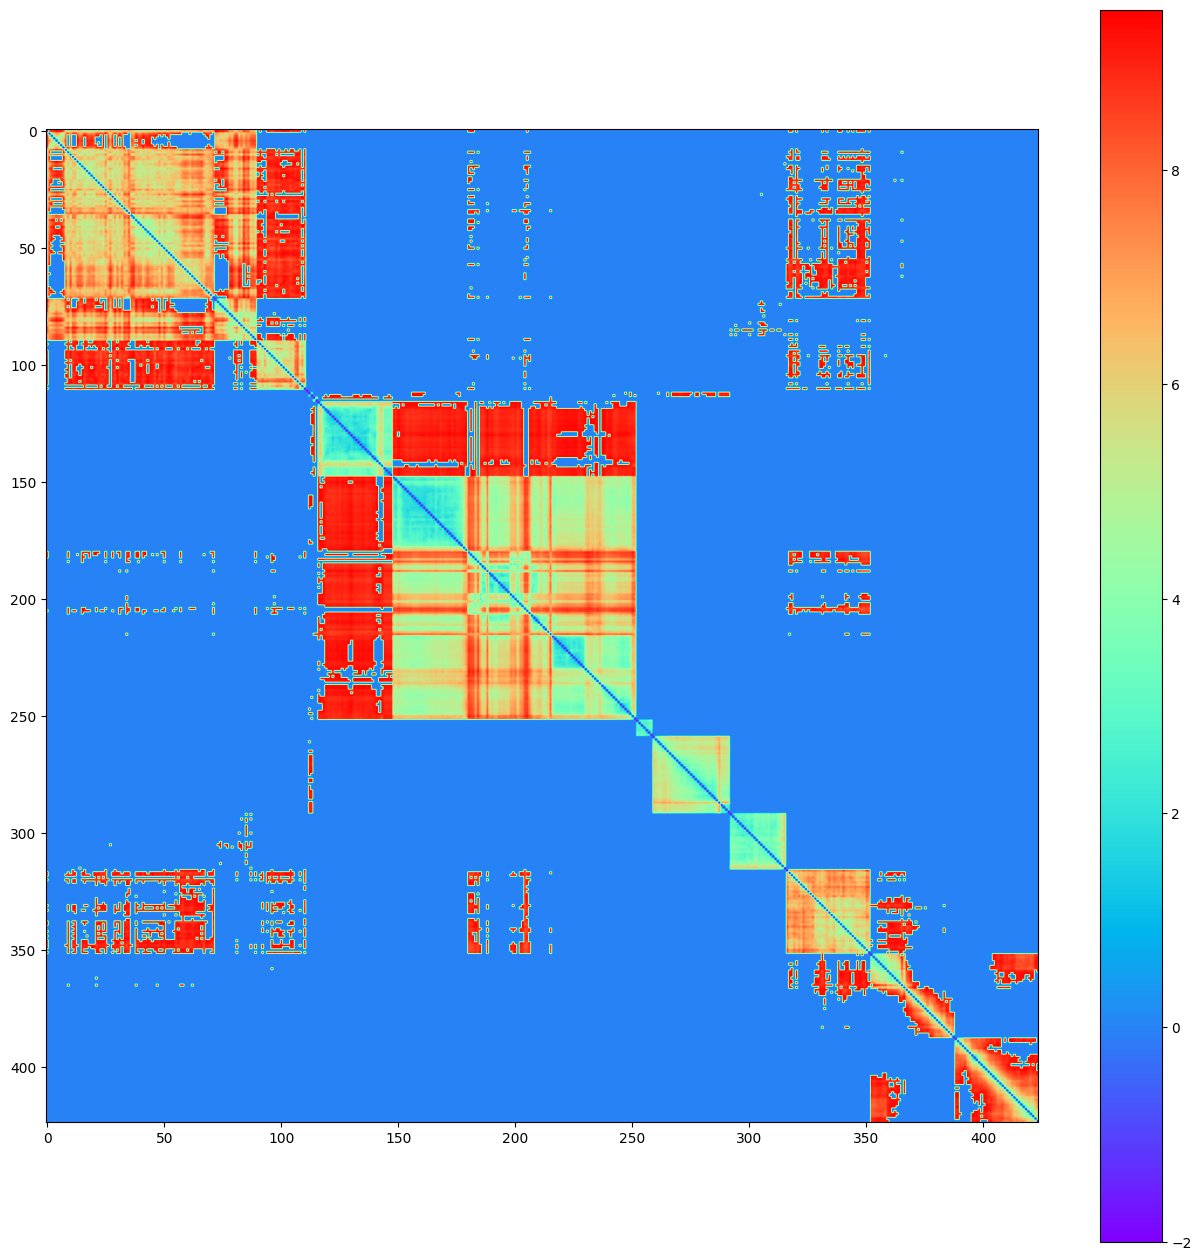

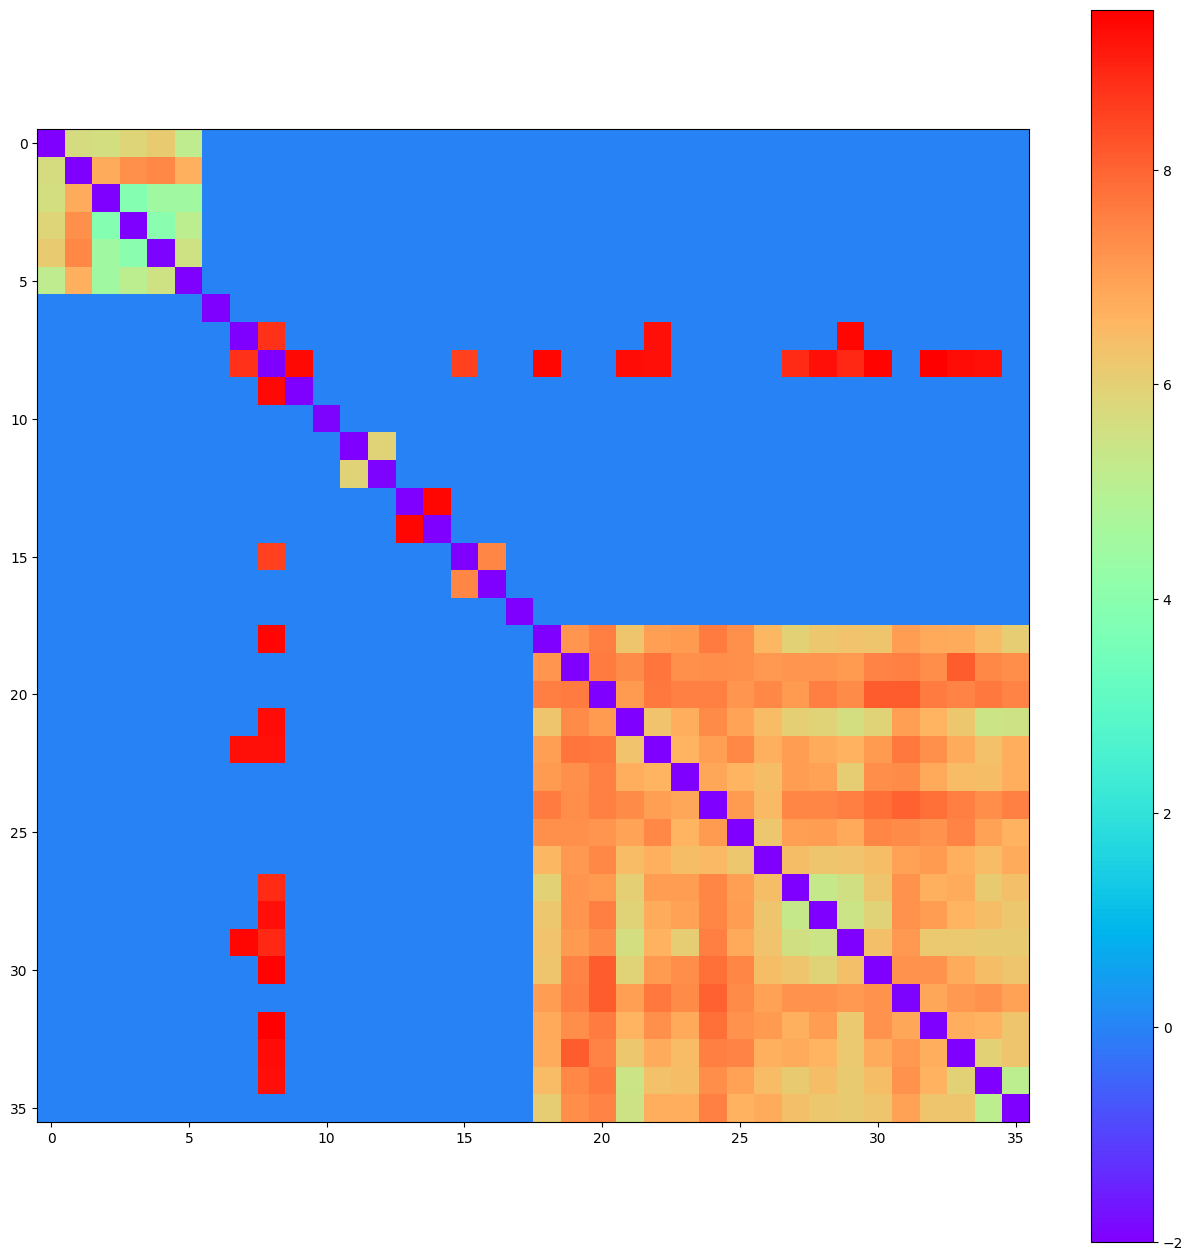

In [ ]:
# tracé matrices de distances
from matplotlib.pyplot import imshow

for i, cam in enumerate(cams):
    print(cam)
    dist = dists[cam]
    plt.figure(i, figsize=(16,16))

    #Visualisation de la matrice des distances entre N et N+v:
    tierce = 0
    N = tierce*60
    v = 1000
    M = (dist)[N:N+v,N:N+v]
    # imshow(M, vmin=0, vmax=10, cmap='jet')
    t = 9.5
    imshow(M *(M<t)  - 2 * (M<0.1), vmin=-2, vmax=t, cmap='rainbow')

    plt.colorbar()

**G.2** Clustering online sur les séries

In [ ]:
oc.eval()
# pas de prise de rique:
# seuil neige: 9.5
#seuil brouillard: 9.25
nb_images_for_init = 1
thresh = 10. #t
with torch.no_grad():
  oc.raw_threshold[0] = torch.tensor([thresh]).cuda()

nc_max = 10
start = 4
cams = sorted([cam for cam in ls(dir_series) if 'webcam' in cam])
preds = {cam:[0 for i in range(nb_images_for_init)] for cam in cams}

for cam in cams:
  # print(cam)
  ds = DS_singleton_sequences(join(dir_series, cam), SC)
  dl = torch.utils.data.DataLoader(ds, shuffle = False, 
                                   batch_size=16, num_workers=0)

  feats = []
  running_preds_byseq = []
  i = 0
  

  with torch.no_grad():
      for images, names in dl:
          # print(names)
          images = images.to(device)
          bs, *_ = images.shape
          with torch.no_grad():
            fv = contrastive_model(images)
          fv = fv.reshape(1, bs, num_latentdims)

          if i==0:
              i = 1
              fv_init = fv[:, :nb_images_for_init, ...]
              nc_max = 5
              oc.init_cluster(fv_init, nc_max)
              idxs = range(nb_images_for_init, bs)
          else:
              idxs = range(bs)

          for k in idxs:
              fv_k = fv[:, k, ...]
              _, _, cluster = oc.forward(fv_k)
              cluster = cluster.item()
              running_preds_byseq.append(cluster)

  preds[cam] += running_preds_byseq
  path_dict_clusters = '/root/' + cam + '_dict_clusters.pt' 
  oc.save_dict_clusters(path_dict_clusters)

      

  

In [ ]:
def reduce(L):
  l = len(L)
  new_L = []
  current_cl = L[0]
  count = 0
  for i, cl in enumerate(L):
    if cl == current_cl:
      count+=1
    else:
      new_L.append((current_cl,count))
      current_cl = cl 
      count = 1
    if i == l-1:
      new_L.append((current_cl,count))
  return new_L


# Etude clusters parasites : 

obs = {}
com = {}
com['webcam1323'] = 'tunnel lac de chanmbon'
obs['webcam1323'] = []

com['webcam1198'] = 'Menat'
obs['webcam1198'] = [(0, 41), (1, 2), ('flou dégressif', 16), (0, 75), ('flou dégressif', 7), (0, 94), (3, 2), (0, 44)]

com['webcam1203'] = 'split flou'
obs['webcam1203'] = [(0, 44), ('0, très flou', 14), ('0, léger flou',13), (0, 17)]

com['webcam1209'] = 'saletés'
obs['webcam1209'] = [(0)]


com['webcam1192'] = 'superbesse, split pixels gris'
obs['webcam1192'] = []

com['webcam1297'] = ''
obs['webcam1297'] = []

com['webcam1296'] = ''
obs['webcam1296'] = []

com['webcam1323'] = 'split camions'
obs['webcam1323'] = []

com['webcam1192'] = ""
obs['webcam1192'] = []

com['webcam1381'] = 'station aigual, split brouillard non rerpoduit à th = 10'
obs['webcam1381'] = []

com['webcam1213'] = 'chalet, zoom' 
obs['webcam1213'] = []

com['webcam1284'] = 'col de la ventouse, Aydat'
obs['webcam1284'] = []



com['webcam1268'] = 'Zoufftgen, brouillard -> split'
obs['webcam1268'] = []

com['webcam1343'] = 'sur faible seuil seulement (9.5)'
obs['webcam1343'] = []

com['webcam1348'] = 'superbe cas: sans neige - flocon + neige neige -> 2 clusters'
obs['webcam1348'] = [(0, 38), (1, 4), (0, 1), (1, 1), (0, 38), (1, 6), ('0, flou', 39), (1, 2), (2, 2), (1, 1), ('0, flou -> non flou', 39), (1, 5), ('0, non flou', 39), (1, 1), (2, 1), (1, 3), (2, 1), (0, 2), ('0, non flou', 37), (1, 4)]

com['webcam1346'] = 'meussia split camions, seuil faible'
obs['webcam1346'] = []

com['webcam1240'] = 'cote de la main, split greypix + flocon - le pb ne semble pas se poser à 10.'
obs['webcam1240'] = []

com['webcam1249'] = 'split  flocon  le pb ne semble pas se poser'
obs['webcam1249'] = []

com['webcam1439'] = 'split défaut image, pas reproduit à 10.'
obs['webcam1439'] = []

com['webcam1230'] = ''
obs['webcam1230'] = []

com['webcam1399'] = 'split flou, très bon exemple'
obs['webcam1399'] = [(0, 44), ('0,flou', 2), (0, 2), ('0, flou', 2), ('0, léger flou' , 3), (0, 17)]

for cam in preds:
  print('-------')
  print(cam)
  # print((preds[cam])) 
  print(com[cam]) 
  print(obs[cam]) 
  print('pred:')
  print(reduce(preds[cam]))  


-------
webcam1192

[]
pred:
[(0, 1), (1, 1), (0, 16), (1, 1), (0, 1)]
-------
webcam1198
Menat
[]
pred:
[(0, 41), (1, 2), (2, 16), (0, 75), (2, 7), (0, 94), (3, 2), (0, 44)]
-------
webcam1203
split flou
[]
pred:
[(0, 44), (1, 27), (0, 17)]
-------
webcam1209

[]
pred:
[(0, 75)]
-------
webcam1213
chalet, zoom
[]
pred:
[(0, 36), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 74)]
-------
webcam1230

[]
pred:
[(0, 1), (1, 4), (2, 39), (1, 1), (2, 16), (3, 16), (2, 11)]
-------
webcam1240
cote de la main, split greypix + flocon
[]
pred:
[(0, 13), (1, 1), (0, 35), (2, 1), (1, 1), (0, 1), (1, 1), (0, 2), (1, 1), (0, 39), (1, 1), (0, 8), (1, 1), (0, 29), (2, 4), (0, 69), (1, 1), (0, 2), (1, 1), (0, 6), (1, 1), (0, 3), (1, 1), (0, 2), (1, 1), (0, 7), (1, 2), (0, 12), (1, 1), (0, 2), (1, 1), (0, 8), (1, 10), (0, 1), (1, 2), (0, 8), (1, 1), (0, 6), (1, 1), (0, 3), (1, 1), (0, 9)]
-------
webcam1249
split  flocon
[]
pred:
[(0, 89), (1, 32), (0, 3), (1, 1), (0, 28), (1, 2), (0, 11), (1, 8)

In [ ]:
def reduce(L):
  l = len(L)
  new_L = []
  current_cl = L[0]
  count = 0
  for i, cl in enumerate(L):
    if cl == current_cl:
      count+=1
    else:
      new_L.append((current_cl,count))
      current_cl = cl 
      count = 1
    if i == l-1:
      new_L.append((current_cl,count))
  return new_L


#Première version : 

obs = {}
com = {}
com['webcam1192'] = 'route campagne, différence peu marquée (shift à droite)'
obs['webcam1192'] = [(0,77),(0.1,18)]

com['webcam1268'] = 'taille des arbres à gauches, brouillard'
obs['webcam1268'] = [(0,36)]

com['webcam1291'] = 'aérodrome, seule la classe 0 est importante:'
obs['webcam1291'] = [(0,33), ('n',3), ('r',35), ('n',1),
                     ('r',34), ('n',2), (0,34), ('n',2), (0,27), ('n',2), (0,34), ('n',2), (0, 36), ('i',144)]

com['webcam1293'] = 'aérodrome différence peu marquée (shift sur pergola)'
obs['webcam1293'] = [(0,27), (0.1,9)]

com['webcam1322'] = 'rond-point brouillard et neige'
obs['webcam1322'] = [(0,39), (1,37), (2,68), (1,4), (2,24)]

com['webcam1324'] = "route forêt brume et neige + appariton d'un timestamp"
obs['webcam1324'] = [(0,23), (1,1), (2,77), (3,7), (0, 170), (2,9), (3,51)]

com['webcam1325'] = 'route forêt neige:'
obs['webcam1325'] = [(0,97), (1, 59), (2,20)]

com['webcam1341'] = 'chalet, zoom' 
obs['webcam1341'] = [(0,27), ('n',3), (0,28), ('n',2), (0.1,33), (0,35)]

com['webcam1347'] = 'champ de feu:'
obs['webcam1347'] = [(0,90), (0.1,21), (1,1), (2,140), (3,7), (0.2,33), (0.3,24), (0.4,36), (0.5,72)]

com['webcam1425'] = 'station de ski translations / rotations'
obs['webcam1425'] = [(0,6), (1.1,1), (1,1), (1.12,2), (0.1,1), (1.3,2), (0.1,1), (2,1), (1,18)]

for cam in preds:
  print('-------')
  print(cam)
  # print((preds[cam])) 
  print(com[cam]) 
  print(obs[cam]) 
  print('pred:')
  print(reduce(preds[cam]))  


-------
webcam1192
route campagne, différence peu marquée (shift à droite)
[(0, 77), (0.1, 18)]
pred:
[(0, 95)]
-------
webcam1268
taille des arbres à gauches, brouillard
[(0, 36)]
pred:
[(0, 36)]
-------
webcam1291
aérodrome, seule la classe 0 est importante:
[(0, 33), ('n', 3), ('r', 35), ('n', 1), ('r', 34), ('n', 2), (0, 34), ('n', 2), (0, 27), ('n', 2), (0, 34), ('n', 2), (0, 36), ('i', 144)]
pred:
[(0, 33), (1, 3), (2, 72), (0, 34), (1, 2), (0, 27), (1, 2), (0, 34), (1, 2), (0, 36), (2, 21), (3, 7), (4, 29), (5, 12), (2, 1), (1, 63), (6, 3), (7, 8)]
-------
webcam1293
aérodrome différence peu marquée (shift sur pergola)
[(0, 27), (0.1, 9)]
pred:
[(0, 27), (1, 9)]
-------
webcam1322
rond-point brouillard et neige
[(0, 39), (1, 37), (2, 68), (1, 4), (2, 24)]
pred:
[(0, 35), (1, 1), (0, 3), (2, 37), (3, 68), (2, 4), (3, 24)]
-------
webcam1324
route forêt brume et neige + appariton d'un timestamp
[(0, 23), (1, 1), (2, 77), (3, 7), (0, 170), (2, 9), (3, 51)]
pred:
[(0, 23), (1, 1), (

In [ ]:
device = 'cuda:0'
oc = OnlineClustering(averaging)
oc = oc.to(device)
oc.eval()

OnlineClustering(
  (perceptron): Sequential(
    (0): Linear(in_features=1, out_features=2, bias=False)
    (1): Softmax(dim=None)
  )
)

In [ ]:
nc_max = 10
start = 4
cams = sorted([cam for cam in ls(dir_series) if 'webcam' in cam])
preds2 = {cam:[] for cam in cams}

for cam in cams:
  # print(cam)
  ds = DS_singleton_sequences(join(dir_series, cam), SC)
  dl = torch.utils.data.DataLoader(ds, shuffle = False, 
                                   batch_size=16, num_workers=0)

  feats = []
  running_preds_byseq = []
  path_dict_clusters = '/root/' + cam + '_dict_clusters.pt' 
  oc.load_dict_clusters(path_dict_clusters)
  
  with torch.no_grad():
      for images, names in dl:
          # print(names)
          images = images.to(device)
          bs, *_ = images.shape
          with torch.no_grad():
            fv = contrastive_model(images)
          fv = fv.reshape(1, bs, num_latentdims)

          idxs = range(bs)

          for k in idxs:
              fv_k = fv[:, k, ...]
              _, _, cluster = oc.forward(fv_k)
              cluster = cluster.item()
              running_preds_byseq.append(cluster)

  preds2[cam] += running_preds_byseq
  oc.save_dict_clusters(path_dict_clusters)

In [ ]:
for cam in preds:
  print('-------')
  print(cam)
  # print((preds[cam])) 
  print(com[cam]) 
  print(obs[cam]) 
  print('pred:')
  print(reduce(preds[cam]))  
  print('pred generation 2:')
  print(reduce(preds2[cam]))  

-------
webcam1192
route campagne, différence peu marquée (shift à droite)
[(0, 77), (0.1, 18)]
pred:
[(0, 95)]
pred generation 2:
[(0, 95)]
-------
webcam1268
taille des arbres à gauches, brouillard
[(0, 36)]
pred:
[(0, 36)]
pred generation 2:
[(0, 36)]
-------
webcam1291
aérodrome, seule la classe 0 est importante:
[(0, 33), ('n', 3), ('r', 35), ('n', 1), ('r', 34), ('n', 2), (0, 34), ('n', 2), (0, 27), ('n', 2), (0, 34), ('n', 2), (0, 36), ('i', 144)]
pred:
[(0, 33), (1, 3), (2, 72), (0, 34), (1, 2), (0, 27), (1, 2), (0, 34), (1, 2), (0, 36), (2, 21), (3, 7), (4, 29), (5, 12), (2, 1), (1, 63), (6, 3), (7, 8)]
pred generation 2:
[(0, 34), (8, 2), (2, 72), (0, 35), (8, 1), (0, 27), (8, 2), (0, 34), (8, 2), (0, 36), (2, 21), (3, 7), (4, 29), (5, 12), (2, 1), (1, 63), (6, 3), (7, 8)]
-------
webcam1293
aérodrome différence peu marquée (shift sur pergola)
[(0, 27), (0.1, 9)]
pred:
[(0, 27), (1, 9)]
pred generation 2:
[(0, 27), (1, 9)]
-------
webcam1322
rond-point brouillard et neige
[(0

In [ ]:
nc_max = 10
start = 4
cams = sorted([cam for cam in ls(dir_series) if 'webcam' in cam])
preds3 = {cam:[] for cam in cams}

for cam in cams:
  # print(cam)
  ds = DS_singleton_sequences(join(dir_series, cam), SC)
  dl = torch.utils.data.DataLoader(ds, shuffle = False, 
                                   batch_size=16, num_workers=0)

  feats = []
  running_preds_byseq = []
  path_dict_clusters = '/root/' + cam + '_dict_clusters.pt' 
  oc.load_dict_clusters(path_dict_clusters)
  
  with torch.no_grad():
      for images, names in dl:
          # print(names)
          images = images.to(device)
          bs, *_ = images.shape
          with torch.no_grad():
            fv = contrastive_model(images)
          fv = fv.reshape(1, bs, num_latentdims)

          idxs = range(bs)

          for k in idxs:
              fv_k = fv[:, k, ...]
              _, _, cluster = oc.forward(fv_k)
              cluster = cluster.item()
              running_preds_byseq.append(cluster)

  preds3[cam] += running_preds_byseq
  # oc.save_dict_clusters(path_dict_clusters)

In [ ]:
for cam in preds:
  print('-------')
  print(cam)
  # print((preds[cam])) 
  print(com[cam]) 
  print(obs[cam]) 
  print('pred:')
  print(reduce(preds[cam]))  
  print('pred generation 2:')
  print(reduce(preds2[cam]))  
  print('pred generation 3:')
  print(reduce(preds3[cam]))  

-------
webcam1192
route campagne, différence peu marquée (shift à droite)
[(0, 77), (0.1, 18)]
pred:
[(0, 95)]
pred generation 2:
[(0, 95)]
pred generation 3:
[(0, 95)]
-------
webcam1268
taille des arbres à gauches, brouillard
[(0, 36)]
pred:
[(0, 36)]
pred generation 2:
[(0, 36)]
pred generation 3:
[(0, 36)]
-------
webcam1291
aérodrome, seule la classe 0 est importante:
[(0, 33), ('n', 3), ('r', 35), ('n', 1), ('r', 34), ('n', 2), (0, 34), ('n', 2), (0, 27), ('n', 2), (0, 34), ('n', 2), (0, 36), ('i', 144)]
pred:
[(0, 33), (1, 3), (2, 72), (0, 34), (1, 2), (0, 27), (1, 2), (0, 34), (1, 2), (0, 36), (2, 21), (3, 7), (4, 29), (5, 12), (2, 1), (1, 63), (6, 3), (7, 8)]
pred generation 2:
[(0, 34), (8, 2), (2, 72), (0, 35), (8, 1), (0, 27), (8, 2), (0, 34), (8, 2), (0, 36), (2, 21), (3, 7), (4, 29), (5, 12), (2, 1), (1, 63), (6, 3), (7, 8)]
pred generation 3:
[(0, 33), (8, 3), (2, 72), (0, 34), (8, 2), (0, 27), (8, 2), (0, 34), (8, 2), (0, 36), (2, 21), (3, 7), (4, 29), (5, 12), (2, 1),

In [344]:
import pandas as pd

A = pd.DataFrame.from_dict({'Names':['A','A', 'B','B'],'Missed':[1,1,2,1],'Credit':[3,1,3,2],'Grades':[10,12,10,20]})

print(A)
funcs = {'Missed':'mean', 'Credit':'max', 'Grades':'sum'}
print(A.agg(func=funcs))

  Names  Missed  Credit  Grades
0     A       1       3      10
1     A       1       1      12
2     B       2       3      10
3     B       1       2      20
Missed     1.25
Credit     3.00
Grades    52.00
dtype: float64
